<a href="https://colab.research.google.com/github/makarandmadhavi/Model-Interpretability-Marketting-Campaign/blob/main/Model_Interpretability_Marketting_Campaign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Interpretability Marketting Campaign

Interpret your models.

1. Fit a linear model and interpret the regression coefficients

2. Fit a tree-based model and interpret the nodes

3.  Use auto ml to find the best model

4. Run SHAP analysis on the models from steps 1, 2, and 3,   interpret the SHAP values and compare them with the other model interpretability methods.

 

Grading:  80% if meet the above requirements

Up to 20% for presentation and expanation.


## About Dataset - Marketing Campaign

Dataset Link - https://www.kaggle.com/datasets/rodsaldanha/arketing-campaign

**Context**
A response model can provide a significant boost to the efficiency of a marketing campaign by increasing responses or reducing expenses. The objective is to predict who will respond to an offer for a product or service

**Content**

1. AcceptedCmp1 - 1 if customer accepted the offer in the 1st campaign, 0 otherwise
2. AcceptedCmp2 - 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
3. AcceptedCmp3 - 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
4. AcceptedCmp4 - 1 if customer accepted the offer in the 4th campaign, 0 otherwise
5. AcceptedCmp5 - 1 if customer accepted the offer in the 5th campaign, 0 otherwise
6. Response (target) - 1 if customer accepted the offer in the last campaign, 0 otherwise
7. Complain - 1 if customer complained in the last 2 years
8. DtCustomer - date of customer’s enrolment with the company
9. Education - customer’s level of education
10. Marital - customer’s marital status
11. Kidhome - number of small children in customer’s household
12. Teenhome - number of teenagers in customer’s household
13. Income - customer’s yearly household income
14. MntFishProducts - amount spent on fish products in the last 2 years
15. MntMeatProducts - amount spent on meat products in the last 2 years
16. MntFruits - amount spent on fruits products in the last 2 years
17. MntSweetProducts - amount spent on sweet products in the last 2 years
18. MntWines - amount spent on wine products in the last 2 years
19. MntGoldProds - amount spent on gold products in the last 2 years
20. NumDealsPurchases - number of purchases made with discount
21. NumCatalogPurchases - number of purchases made using catalogue
22. NumStorePurchases - number of purchases made directly in stores
23. NumWebPurchases - number of purchases made through company’s web site
24. NumWebVisitsMonth - number of visits to company’s web site in the last month
25. Recency - number of days since the last purchase

In [33]:
!pip install h2o

In [34]:
!pip install graphviz

In [35]:
!pip install shap

In [36]:
#Importing required packages
import h2o
from h2o.automl import H2OAutoML
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.ensemble import RandomForestRegressor
pd.options.display.max_columns = None

In [37]:
data = pd.read_csv("https://raw.githubusercontent.com/makarandmadhavi/ML-Data-Cleaning-and-Feature-Selection/main/marketing_campaign.csv", sep=";")
data.drop(columns = ["Z_CostContact","Z_Revenue","ID",],inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year_Birth           2240 non-null   int64  
 1   Education            2240 non-null   object 
 2   Marital_Status       2240 non-null   object 
 3   Income               2216 non-null   float64
 4   Kidhome              2240 non-null   int64  
 5   Teenhome             2240 non-null   int64  
 6   Dt_Customer          2240 non-null   object 
 7   Recency              2240 non-null   int64  
 8   MntWines             2240 non-null   int64  
 9   MntFruits            2240 non-null   int64  
 10  MntMeatProducts      2240 non-null   int64  
 11  MntFishProducts      2240 non-null   int64  
 12  MntSweetProducts     2240 non-null   int64  
 13  MntGoldProds         2240 non-null   int64  
 14  NumDealsPurchases    2240 non-null   int64  
 15  NumWebPurchases      2240 non-null   i

# EDA Data Cleaning and feature engineering


In [38]:

data.head()

Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0        1957  Graduation         Single  58138.0        0         0   
1        1954  Graduation         Single  46344.0        1         1   
2        1965  Graduation       Together  71613.0        0         0   
3        1984  Graduation       Together  26646.0        1         0   
4        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  MntFruits  MntMeatProducts  MntFishProducts  \
0  2012-09-04       58       635         88              546              172   
1  2014-03-08       38        11          1                6                2   
2  2013-08-21       26       426         49              127              111   
3  2014-02-10       26        11          4               20               10   
4  2014-01-19       94       173         43              118               46   

   MntSweetProducts  MntGoldProds  NumDealsPurchases  NumWebPurchases  \
0                88            88                  3                8   
1                 1             6                  2                1   
2                21            42                  1                8   
3                 3             5                  2                2   
4                27            15                  5                5   

   NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  AcceptedCmp3  \
0                   10                  4                  7             0   
1                    1                  2                  5             0   
2                    2                 10                  4             0   
3                    0                  4                  6             0   
4                    3                  6                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  Response  
0             0             0             0             0         0         1  
1             0             0             0             0         0         0  
2             0             0             0             0         0         0  
3             0             0             0             0         0         0  
4             0             0             0             0         0         0

In [39]:
data['Income'].fillna(data.groupby('Education')['Income'].transform('mean'), inplace = True)
data['Year_Birth'] = data['Year_Birth'].apply(lambda x: 2020-x)
data = data.rename(columns={'Year_Birth': 'Age'})

Education_map = {'Basic':1,
            'Graduation':2,
            'Master':3,
            '2n Cycle':3,
            'PhD':4}
# Create the mapped values in a new column
data['Education'] = data['Education'].map(Education_map)

from datetime import datetime
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'], format='%Y-%m-%d')
data['Dt_Customer'] = (datetime(2020,1,1) - data['Dt_Customer']).dt.days

data['Children'] = data['Kidhome'] + data['Teenhome']
data.drop(columns = ["Kidhome","Teenhome"],inplace = True)

data['AmountSpent'] = data['MntWines'] + data['MntFruits'] + data['MntMeatProducts'] + data['MntFishProducts'] + data['MntSweetProducts'] + data['MntGoldProds']
data.drop(columns = ["MntWines",	"MntFruits"	,"MntMeatProducts",	"MntFishProducts","MntSweetProducts",	"MntGoldProds"],inplace = True)

data['NumPurchased'] = data['NumWebPurchases'] + data['NumCatalogPurchases'] + data['NumStorePurchases']
data.drop(columns = ["NumWebPurchases",	"NumCatalogPurchases",	"NumStorePurchases"],inplace = True)

data['Prev_campaigns'] = data['AcceptedCmp1'] + data['AcceptedCmp2'] + data['AcceptedCmp3'] + data['AcceptedCmp4'] + data['AcceptedCmp5']
data.drop(columns = ["AcceptedCmp3",	"AcceptedCmp4",	"AcceptedCmp5",	"AcceptedCmp1",	"AcceptedCmp2"],inplace = True)

maratial_map = {'Married':"Couple",
            'Together':"Couple",
            'Single':'Single',
            'Divorced':'Single',
            'Widow':'Single',
            'Alone':'Single',
            'Absurd':'Single',
            'YOLO':'Single'}
# Create the mapped values in a new column
data['Marital_Status'] = data['Marital_Status'].map(maratial_map)

dummy_status = pd.get_dummies(data['Marital_Status'], prefix='Marital_Status')

data = pd.concat([data, dummy_status], axis=1)
data.drop(['Marital_Status'], axis=1, inplace=True)
data.drop(['Marital_Status_Single'], axis=1, inplace=True)


data.head()

Age  Education   Income  Dt_Customer  Recency  NumDealsPurchases  \
0   63          2  58138.0         2675       58                  3   
1   66          2  46344.0         2125       38                  2   
2   55          2  71613.0         2324       26                  1   
3   36          2  26646.0         2151       26                  2   
4   39          4  58293.0         2173       94                  5   

   NumWebVisitsMonth  Complain  Response  Children  AmountSpent  NumPurchased  \
0                  7         0         1         0         1617            22   
1                  5         0         0         2           27             4   
2                  4         0         0         0          776            20   
3                  6         0         0         1           53             6   
4                  5         0         0         1          422            14   

   Prev_campaigns  Marital_Status_Couple  
0               0                      0  
1               0                      0  
2               0                      1  
3               0                      1  
4               0                      1

In [40]:
data.Income.quantile(0.99)

94437.68000000001

In [41]:
data.drop(data[data['Income'] >= 94437].index, inplace = True)


In [42]:
data.isnull().sum()


Age                      0
Education                0
Income                   0
Dt_Customer              0
Recency                  0
NumDealsPurchases        0
NumWebVisitsMonth        0
Complain                 0
Response                 0
Children                 0
AmountSpent              0
NumPurchased             0
Prev_campaigns           0
Marital_Status_Couple    0
dtype: int64

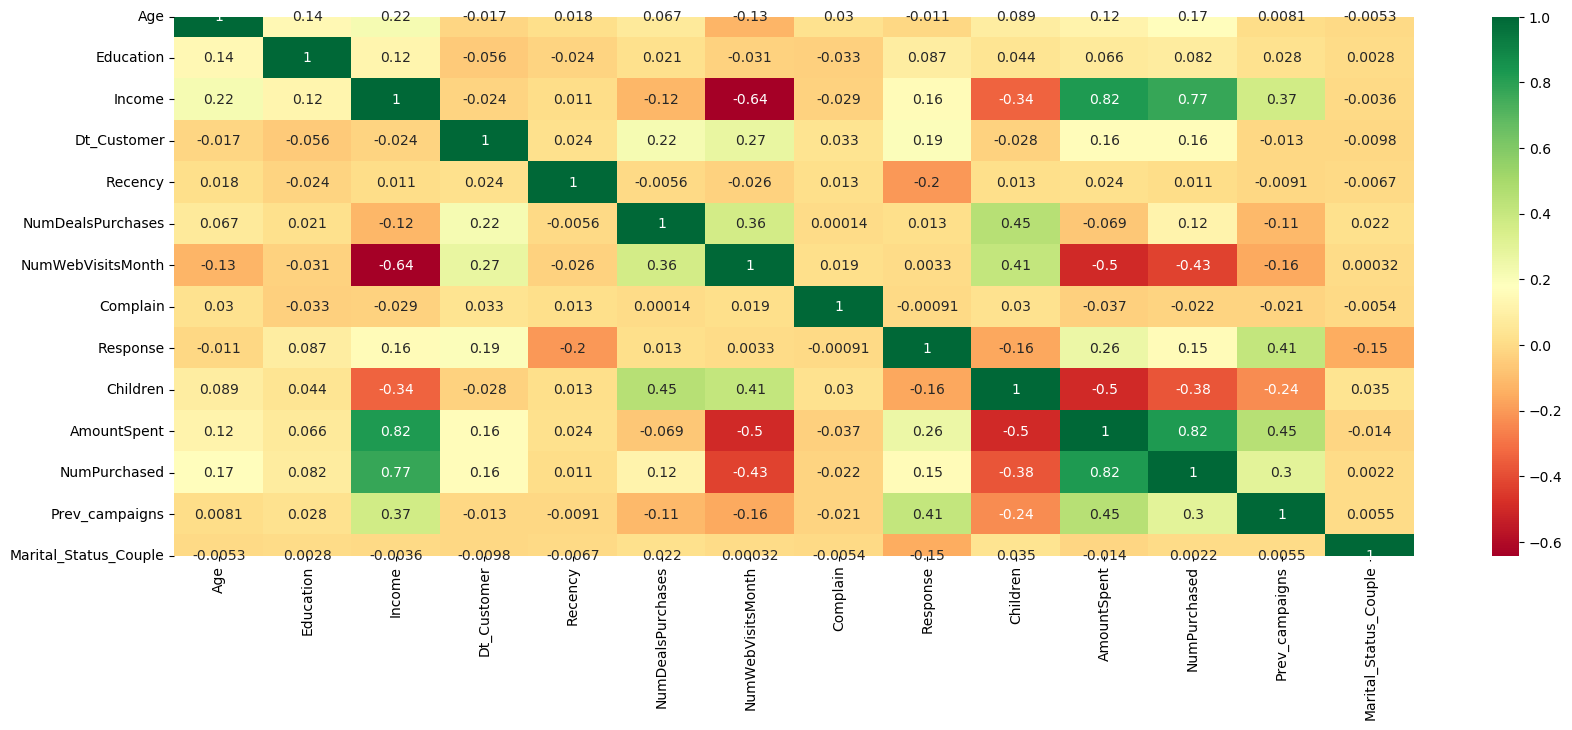

In [43]:
plt.figure(figsize=(20,7))
sns.heatmap(data.corr(), annot=True, cmap='RdYlGn')

# Logistic Regression ( Linear model )

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split

In [45]:
y=data['Response']#specify the dependent variable and independent variable
x=data.drop(['Response'],axis=1)
x.head()

Age  Education   Income  Dt_Customer  Recency  NumDealsPurchases  \
0   63          2  58138.0         2675       58                  3   
1   66          2  46344.0         2125       38                  2   
2   55          2  71613.0         2324       26                  1   
3   36          2  26646.0         2151       26                  2   
4   39          4  58293.0         2173       94                  5   

   NumWebVisitsMonth  Complain  Children  AmountSpent  NumPurchased  \
0                  7         0         0         1617            22   
1                  5         0         2           27             4   
2                  4         0         0          776            20   
3                  6         0         1           53             6   
4                  5         0         1          422            14   

   Prev_campaigns  Marital_Status_Couple  
0               0                      0  
1               0                      0  
2               0                      1  
3               0                      1  
4               0                      1

In [46]:
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.8)#divide the train ,test group
x_train.head()

Age  Education   Income  Dt_Customer  Recency  NumDealsPurchases  \
1700   44          2  61064.0         2679       80                  5   
1068   64          2  22304.0         2706       91                  1   
2076   43          3  27889.0         2371       42                  1   
1069   42          2  67023.0         2129       93                  1   
733    72          4  45072.0         2268       74                  5   

      NumWebVisitsMonth  Complain  Children  AmountSpent  NumPurchased  \
1700                  6         0         1         1080            23   
1068                  8         0         0           18             3   
2076                  6         0         1           26             4   
1069                  2         1         0          906            23   
733                   8         0         3          284            11   

      Prev_campaigns  Marital_Status_Couple  
1700               0                      1  
1068               0                      0  
2076               0                      1  
1069               0                      1  
733                0                      0

In [47]:
logreg=LogisticRegression()
loggreg_final=logreg.fit(x_train,y_train)
print(loggreg_final.score(x_train,y_train))

0.8527918781725888


In [48]:
y_pred=logreg.predict(x_test)

cm=confusion_matrix(y_test, y_pred)#confusion matrix for the logistic model prediction
print(cm)

[[367   9]
 [ 53  15]]


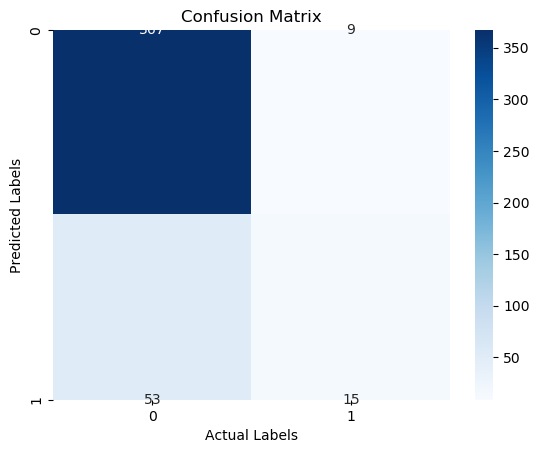

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.show()


In [50]:
#Using OLS for finding the p value to check the significant features
import statsmodels.api as sm

model = sm.OLS(data['Response'], data[["Age",	"Education",	"Income",	"Dt_Customer",	
                                       "Recency"	,"NumDealsPurchases",	"NumWebVisitsMonth",	
                                       "Complain",	"Children",	"AmountSpent"	,"NumPurchased",	
                                       "Prev_campaigns",	"Marital_Status_Couple"]]).fit()

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               Response   R-squared (uncentered):                   0.386
Model:                            OLS   Adj. R-squared (uncentered):              0.382
Method:                 Least Squares   F-statistic:                              106.6
Date:                Wed, 29 Mar 2023   Prob (F-statistic):                   3.50e-222
Time:                        20:12:31   Log-Likelihood:                         -473.21
No. Observations:                2217   AIC:                                      972.4
Df Residuals:                    2204   BIC:                                      1047.
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Age                      -0.0009      0.001     -1.672      0.095      -0.002       0.000
Education                 0.0283      0.008      3.710      0.000       0.013       0.043
Income                -1.245e-06   6.66e-07     -1.870      0.062   -2.55e-06    6.05e-08
Dt_Customer               0.0001   1.92e-05      6.866      0.000    9.43e-05       0.000
Recency                  -0.0026      0.000    -11.710      0.000      -0.003      -0.002
NumDealsPurchases         0.0155      0.004      3.517      0.000       0.007       0.024
NumWebVisitsMonth         0.0047      0.004      1.175      0.240      -0.003       0.013
Complain                  0.0511      0.066      0.774      0.439      -0.078       0.181
Children                 -0.0428      0.012     -3.584      0.000      -0.066      -0.019
AmountSpent               0.0001   2.45e-05      5.335      0.000    8.26e-05       0.000
NumPurchased             -0.0065      0.002     -3.591      0.000      -0.010      -0.003
Prev_campaigns            0.1945      0.011     17.454      0.000       0.173       0.216
Marital_Status_Couple    -0.1165      0.013     -8.768      0.000      -0.143      -0.090
==============================================================================
Omnibus:                      537.661   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1111.189
Skew:                           1.413   Prob(JB):                    5.11e-242
Kurtosis:                       5.011   Cond. No.                     5.72e+05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 5.72e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Interpretting the Regression Coefficients

The coefficients of the independent variables in the regression model represent the change in the dependent variable for a one-unit increase in the corresponding independent variable, holding all other independent variables constant.

1. The coefficient for "Age" is -0.0013. This means that for every one unit increase in age, the dependent variable (Response) is expected to decrease by 0.0013, holding all other variables constant.

2. The coefficient for "Education" is 0.0266. This means that for every one unit increase in education, the dependent variable is expected to increase by 0.0266, holding all other variables constant.

3. The coefficient for "Income" is -5.288e-07. This means that for every one unit increase in income, the dependent variable is expected to decrease by 5.288e-07, holding all other variables constant. However, the p-value associated with this coefficient is 0.149, which is greater than the commonly used threshold of 0.05, indicating that this coefficient may not be statistically significant.

4. The coefficient for "Complain" is 0.0514, but the p-value associated with this coefficient is 0.438, which is greater than 0.05, indicating that this variable may not be statistically significant in the model.

5. The coefficients for "Recency", "Children", "AmountSpent", "NumPurchased", "Prev_campaigns", and "Marital_Status_Couple" all have p-values less than 0.05, indicating that they are statistically significant in the model.

It is important to note that the coefficients should be interpreted with caution, as the presence of multicollinearity or other numerical problems can affect their validity. Therefore, it is recommended to further investigate the model to ensure the robustness of the results.

The adjusted R-squared value is 0.391, which means that about 39.1% of the variability in the response variable can be explained by the independent variables in the model. The F-statistic is 111.8, and the p-value associated with it is very low (1.18e-231), which suggests that at least one of the independent variables is significantly related to the response variable.

The coefficients of the independent variables represent the amount of change in the dependent variable for a one-unit increase in the corresponding independent variable, holding all other independent variables constant. The p-value associated with each coefficient represents the statistical significance of that variable, i.e., whether or not the variable is significantly related to the response variable.

The model does not contain a constant, as indicated by the note [1], which means that the intercept is zero. The note [2] indicates that the standard errors assume that the covariance matrix of the errors is correctly specified.

The large condition number (6.03e+05) mentioned in note [3] suggests that there may be strong multicollinearity or other numerical problems in the model. This should be further investigated to ensure the validity of the results.

Overall, the model appears to be a good fit for the data, but further analysis is needed to assess the robustness of the results.



# Decision Tree (Tree based model)


Accuracy Score: 0.8355855855855856
Confusion Matrix:
[[340  36]
 [ 37  31]]

Decision Tree:



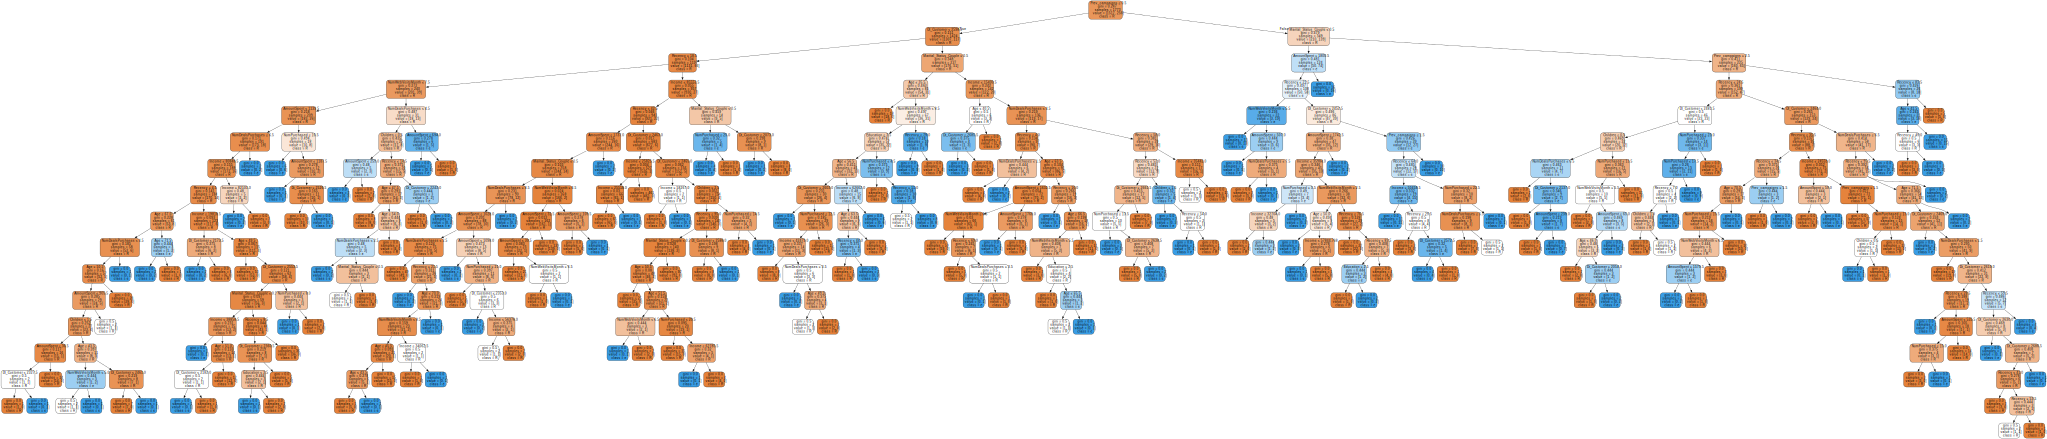

In [51]:
# Import required libraries
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import graphviz

# Create a decision tree classifier
dtc = DecisionTreeClassifier(random_state=42)

# Train the decision tree classifier on the training set
dtc.fit(x_train, y_train)

# Use the decision tree classifier to make predictions on the testing set
y_pred = dtc.predict(x_test)

# Calculate accuracy score and confusion matrix
acc_score = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)

# Print the accuracy score and confusion matrix
print("Accuracy Score: {}".format(acc_score))
print("Confusion Matrix:\n{}".format(conf_mat))

# Visualize the decision tree using graphviz
dot_data = export_graphviz(dtc, out_file=None, feature_names=x_train.columns, class_names=y_train.name, filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph.render("breast_cancer_decision_tree")

# Print the decision tree
print("\nDecision Tree:\n")
graph = graphviz.Source(dot_data)
graph


## Interpretting the tree

The Gini value, also known as the Gini index or Gini impurity, is a measure of the impurity or randomness of a set of data, often used in decision trees. In decision trees, the Gini value is used to determine the optimal split at each node based on the purity of the data subsets resulting from the split.

The Gini value ranges from 0 to 1, with 0 indicating perfect purity (all data belongs to the same class) and 1 indicating perfect impurity (data is evenly distributed among all classes). In decision trees, the Gini value is calculated for each potential split, and the split with the lowest Gini value is chosen as the optimal split.

In practice, the Gini value is often used in conjunction with other measures of impurity, such as entropy, to help build more accurate decision trees.

As we have a problem og binary classification the model a split decision at every node depending on the given parameter value.

In [52]:

# Get numerical feature importances
tree_importances = list(dtc.feature_importances_)
# List of tuples with variable and importance
feature_importances = [
    (feature, round(importance, 2))
    for feature, importance in zip(x_train.columns, tree_importances)
]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

In [53]:

# Print out the feature and importances
[print("Variable: {:20} Importance: {}".format(*pair)) for pair in feature_importances];

Variable: Recency              Importance: 0.16
Variable: Prev_campaigns       Importance: 0.16
Variable: Dt_Customer          Importance: 0.15
Variable: Age                  Importance: 0.09
Variable: AmountSpent          Importance: 0.09
Variable: Income               Importance: 0.07
Variable: NumDealsPurchases    Importance: 0.07
Variable: NumPurchased         Importance: 0.07
Variable: Marital_Status_Couple Importance: 0.06
Variable: NumWebVisitsMonth    Importance: 0.05
Variable: Education            Importance: 0.02
Variable: Children             Importance: 0.01
Variable: Complain             Importance: 0.0


## Interpretting variable importance

The feature importance shows Prev_campaign, Dt_Customer, Recency and Income have a high significance similar to the linear model

# Auto ML

In [54]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


--------------------------  --------------------------------------
H2O_cluster_uptime:         7 days 4 hours 46 mins
H2O_cluster_timezone:       America/New_York
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.40.0.1
H2O_cluster_version_age:    1 month and 21 days
H2O_cluster_name:           H2O_from_python_makarandmadhavi_qzjua0
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.512 Gb
H2O_cluster_total_cores:    8
H2O_cluster_allowed_cores:  8
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.9.12 final
--------------------------  --------------------------------------

In [55]:
df = h2o.H2OFrame(data)
df["Response"] = df["Response"].asfactor()
df.describe(chunk_summary=True)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Rows:2217
Cols:14

Chunk compression summary: 
chunk_type    chunk_name                 count    count_percentage    size     size_percentage
------------  -------------------------  -------  ------------------  -------  -----------------
CBS           Binary                     2        14.2857             696  B   1.51627
CXI           Sparse Integers            1        7.14286             118  B   0.257069
C1N           1-Byte Integers (w/o NAs)  8        57.1429             17.9 KB  39.824
C2            2-Byte Integers            2        14.2857             8.8 KB   19.6157
C8D           64-bit Reals               1        7.14286             17.4 KB  38.787

Frame distribution summary: 
                 size     number_of_rows    number_of_chunks_per_column    number_of_chunks
---------------  -------  ----------------  -----------------------------  ------------------
127.0.0.1:54321  44.8 KB  2217              1                              14
mean             44.8 KB  2217              1                              14
min              44.8 KB  2217              1                              14
max              44.8 KB  2217              1                              14
stddev           0  B     0                 0                              0
total            44.8 KB  2217              1                              14

Age                Education           Income             Dt_Customer         Recency            NumDealsPurchases    NumWebVisitsMonth    Complain              Response    Children            AmountSpent        NumPurchased        Prev_campaigns      Marital_Status_Couple
-------  -----------------  ------------------  -----------------  ------------------  -----------------  -------------------  -------------------  --------------------  ----------  ------------------  -----------------  ------------------  ------------------  -----------------------
type     int                int                 real               int                 int                int                  int                  int                   enum        int                 int                int                 int                 int
mins     24.0               1.0                 1730.0             2012.0              0.0                0.0                  0.0                  0.0                               0.0                 5.0                0.0                 0.0                 0.0
mean     51.22688317546235  2.663509246729812   51324.61926977652  2365.7640956247174  49.17230491655391  2.3306269733874645   5.350924672981507    0.009472259810554804              0.9566982408660358  599.4686513306268  12.479025710419483  0.2873252142534956  0.645466847090663
maxs     127.0              4.0                 94384.0            2711.0              99.0               15.0                 20.0                 1.0                               3.0                 2525.0             32.0                4.0                 1.0
sigma    11.97328701228253  0.8387549593273527  20292.10655022477  202.14067556410893  28.9367711331267   1.8943973099903892   2.4079610557561093   0.09688534513058857               0.7504039318767902  597.240110870126   7.151067007037491   0.6615994453195736  0.478479532763035
zeros    0                  0                   0                  0                   28                 33                   7                    2196                              621                 0                  4                   1768                786
missing  0                  0                   0                  0                   0                  0                    0                    0                     0           0                   0                  0                   0                   0
0        63.0               2.0                 58138.0            2675.0              58.0               3.0                  7.0                  0.0                   1           0.0                 1617.0             22.0                0.0                 0.0
1        66.0               2.0                 46344.0            2125.0              38.0               2.0                  5.0                  0.0                   0           2.0                 27.0               4.0                 0.0                 0.0
2        55.0               2.0                 71613.0            2324.0              26.0               1.0                  4.0                  0.0                   0           0.0                 776.0              20.0                0.0                 1.0
3        36.0               2.0                 26646.0            2151.0              26.0               2.0                  6.0                  0.0                   0           1.0                 53.0               6.0                 0.0                 1.0
4        39.0               4.0                 58293.0            2173.0              94.0               5.0                  5.0                  0.0                   0           1.0                 422.0              14.0                0.0                 1.0
5        53.0               3.0                 62513.0            2305.0              16.0               2.0                  6.0                  0.0                   0           1.0                 716.0              20.0          

In [56]:
train, test, valid = df.split_frame(ratios=[0.7, 0.20], seed=1)

In [57]:
aml = H2OAutoML(max_models=10, balance_classes=True, seed=1)
aml.train(training_frame = train, y = 'Response')

AutoML progress: |
20:12:33.8: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_BestOfFamily_1_AutoML_7_20230329_201233


Model Summary for Stacked Ensemble: 
key                                        value
-----------------------------------------  ----------------
Stacking strategy                          cross_validation
Number of base models (used / total)       5/5
# GBM base models (used / total)           1/1
# GLM base models (used / total)           1/1
# DRF base models (used / total)           2/2
# DeepLearning base models (used / total)  1/1
Metalearner algorithm                      GLM
Metalearner fold assignment scheme         Random
Metalearner nfolds                         5
Metalearner fold_column
Custom metalearner hyperparameters         None

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.04597692444921169
RMSE: 0.21442230399193946
LogLoss: 0.16079441785522292
AUC: 0.9727654534439688
AUCPR: 0.8643611765568621
Gini: 0.9455309068879376
Null degrees of freedom: 1570
Residual degrees of freedom: 1565
Null deviance: 1261.675495959801
Residual deviance: 505.2160609011103
AIC: 517.2160609011103

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2864667405098698
       0     1    Error    Rate
-----  ----  ---  -------  -------------
0      1284  70   0.0517   (70.0/1354.0)
1      28    189  0.129    (28.0/217.0)
Total  1312  259  0.0624   (98.0/1571.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.286467     0.794118  175
max f2                       0.196316     0.843571  218
max f0point5                 0.459237     0.825496  128
max accuracy                 0.459237     0.945258  128
max precision                0.99441      1         0
max recall                   0.0506441    1         318
max specificity              0.99441      1         0
max absolute_mcc             0.286467     0.761814  175
max min_per_class_accuracy   0.218919     0.909897  204
max mean_per_class_accuracy  0.196316     0.920371  218
max tns                      0.99441      1354      0
max fns                      0.99441      216       0
max fps                      0.000549947  1354      399
max tps                      0.0506441    217       318
max tnr                      0.99441      1         0
max fnr                      0.99441      0.995392  0
max fpr                      0.000549947  1         399
max tpr                      0.0506441    1         318

Gains/Lift Table: Avg response rate: 13.81 %, avg score: 14.64 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0101846                   0.929615           7.23963    7.23963            1                0.955766    1                           0.955766            0.0737327       0.0737327                  623.963   623.963            0.0737327
2        0.0203692                   0.893241           7.23963    7.23963            1                0.911604    1                           0.933685            0.0737327       0.147465                   623.963   623.963            0.147465
3        0.0305538                   0.853522           6.33468    6.93798            0.875            0.870842    0.958333                    0.912737            0.0645161       0.211982                   533.468   593.798            0.210504
4        0.0401018                   0.798087           7.23963 

In [58]:
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id                                                      auc    logloss     aucpr    mean_per_class_error      rmse        mse
-------------------------------------------------------  --------  ---------  --------  ----------------------  --------  ---------
StackedEnsemble_BestOfFamily_1_AutoML_7_20230329_201233  0.886128   0.263089  0.604374                0.22541   0.2815    0.0792425
StackedEnsemble_AllModels_1_AutoML_7_20230329_201233     0.883654   0.264944  0.599696                0.220713  0.282561  0.0798405
GBM_1_AutoML_7_20230329_201233                           0.877708   0.278536  0.582157                0.240697  0.291275  0.0848412
GLM_1_AutoML_7_20230329_201233                           0.864508   0.278946  0.572324                0.259691  0.288404  0.0831768
GBM_3_AutoML_7_20230329_201233                           0.855822   0.322371  0.506239                0.250609  0.311562  0.0970708
DRF_1_AutoML_7_20230329_201233                           0.855072   0.581238  0.497318                0.277651  0.329099  0.108306
DeepLearning_1_AutoML_7_20230329_201233                  0.854999   0.295583  0.549121                0.280975  0.297584  0.0885565
GBM_4_AutoML_7_20230329_201233                           0.849875   0.331622  0.494647                0.25851   0.314132  0.0986787
GBM_5_AutoML_7_20230329_201233                           0.847351   0.326679  0.493974                0.270135  0.312611  0.0977258
GBM_2_AutoML_7_20230329_201233                           0.84616    0.32309   0.50938                 0.233845  0.31006   0.0961373
XRT_1_AutoML_7_20230329_201233                           0.846014   0.37124   0.466359                0.248513  0.330679  0.109349
GBM_grid_1_AutoML_7_20230329_201233_model_1              0.832405   0.3442    0.45278                 0.266915  0.321084  0.103095
[12 rows x 7 columns]

In [59]:
#Getting the best model
best_model = h2o.get_model(lb[0,"model_id"])
best_model.model_performance(test)

ModelMetricsBinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.08632325837491578
RMSE: 0.29380819997902674
LogLoss: 0.2803221121643398
AUC: 0.9037802607076351
AUCPR: 0.7009424449480349
Gini: 0.8075605214152701
Null degrees of freedom: 432
Residual degrees of freedom: 427
Null deviance: 403.3683590121891
Residual deviance: 242.7589491343183
AIC: 254.7589491343183

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22320420839468122
       0    1    Error    Rate
-----  ---  ---  -------  ------------
0      317  41   0.1145   (41.0/358.0)
1      17   58   0.2267   (17.0/75.0)
Total  334  99   0.1339   (58.0/433.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.223204     0.666667  95
max f2                       0.119242     0.754505  139
max f0point5                 0.481727     0.692884  44
max accuracy                 0.481727     0.886836  44
max precision                0.970905     1         0
max recall                   0.00177075   1         381
max specificity              0.970905     1         0
max absolute_mcc             0.223204     0.593663  95
max min_per_class_accuracy   0.168515     0.826667  117
max mean_per_class_accuracy  0.200939     0.839628  104
max tns                      0.970905     358       0
max fns                      0.970905     74        0
max fps                      0.000351029  358       399
max tps                      0.00177075   75        381
max tnr                      0.970905     1         0
max fnr                      0.970905     0.986667  0
max fpr                      0.000351029  1         399
max tpr                      0.00177075   1         381

Gains/Lift Table: Avg response rate: 17.32 %, avg score: 15.09 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0138568                   0.912902           5.77333   5.77333            1                0.934059    1                           0.934059            0.08            0.08                       477.333   477.333            0.08
2        0.0207852                   0.861659           5.77333   5.77333            1                0.888645    1                           0.918921            0.04            0.12                       477.333   477.333            0.12
3        0.0300231                   0.827901           2.88667   4.88513            0.5              0.842349    0.846154                    0.89536             0.0266667       0.146667                   188.667   388.513            0.14108
4        0.0415704                   0.770558           5.77333   5.13185            1                0.79365     0.888889                    0.867107            0.0666667       0.213333                   477.333   413.185            0.207747
5        0.0508083                   0.641853           4.33      4.98606            0.75             0.702127    0.863636                    0.837111            0.04            0.253333                   333       398.606            0.244953
6        0.101617                    0.520318           3.67394   4.33               0.636364         0.569851    0.75                        0.703481            0.186667        0.44                       267.394   333                0.409274
7        0.150115                    0.349385           2.47429   3.73046            0.428571         0.420196    0.646154                    0.611958            0.12

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

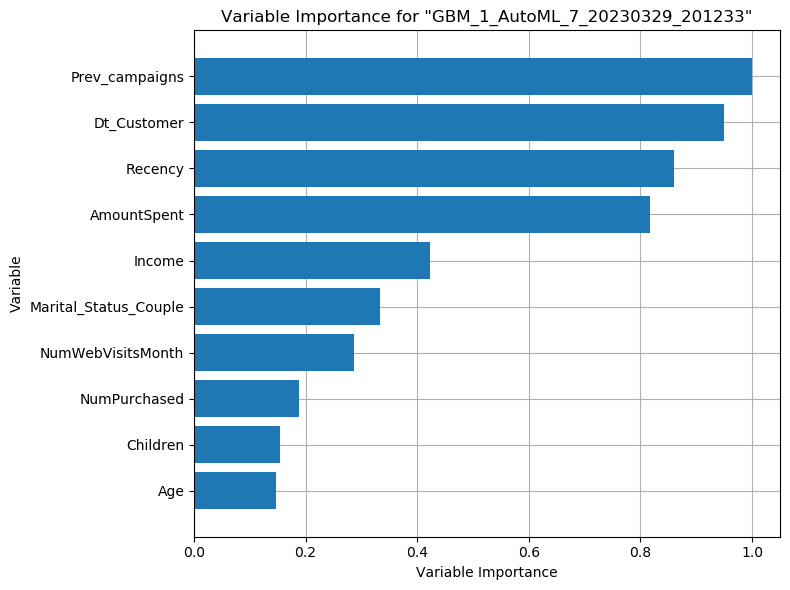

In [60]:
explain_model = aml.explain(frame = test, figsize = (8,6),include_explanations=['varimp'])


## Interpreting Variable Importance

The variable importance graph of best model of autoML shows us thet Prev_campaign is most important feature of the model followed by amount spent and Dt_customer, recency

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

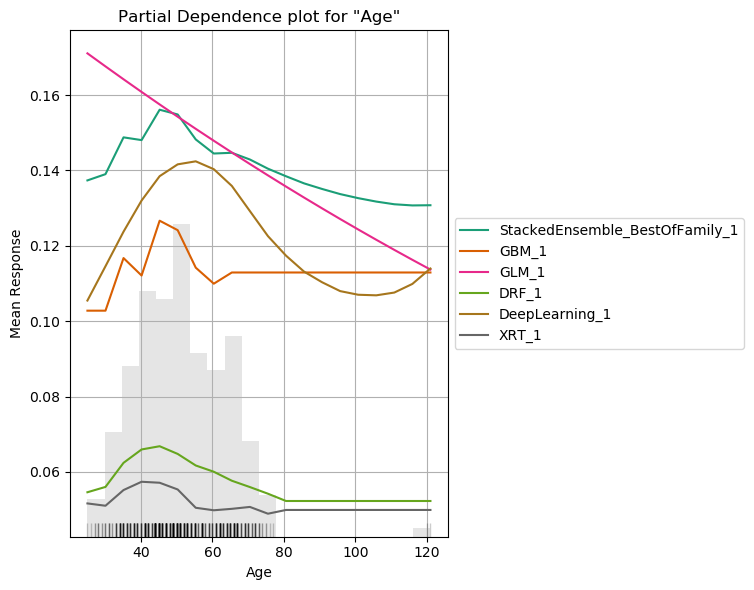

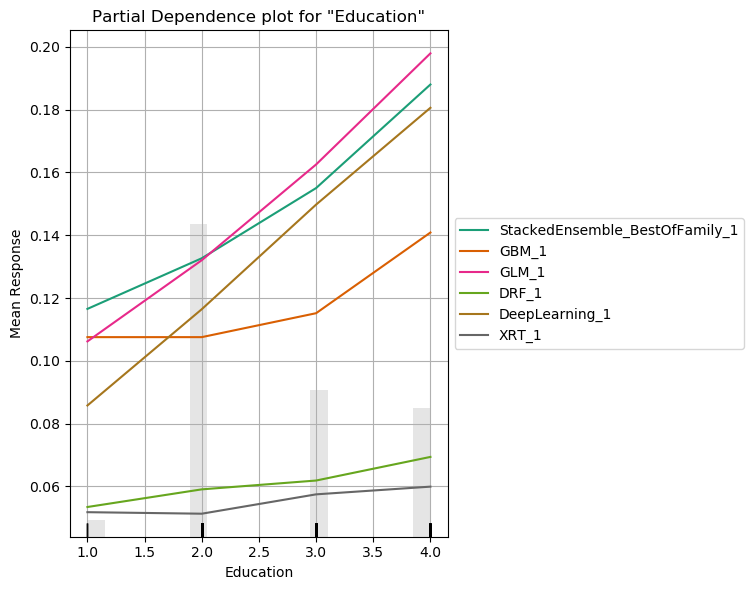

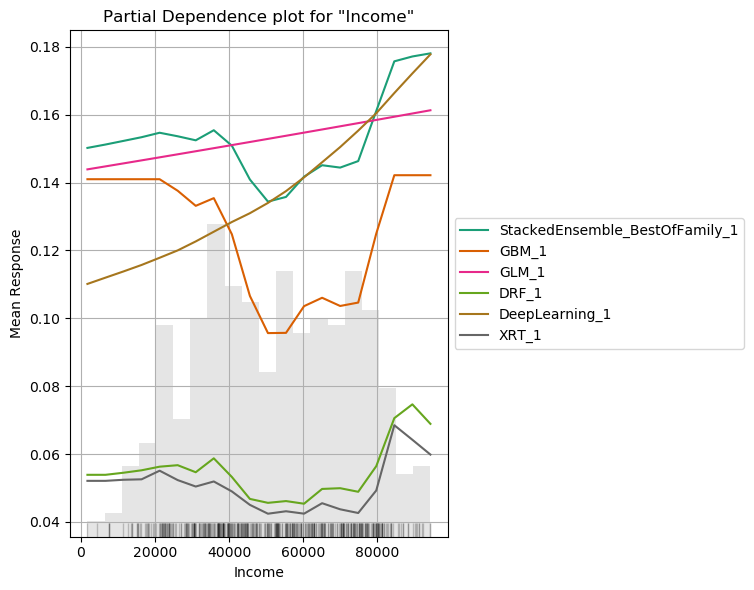

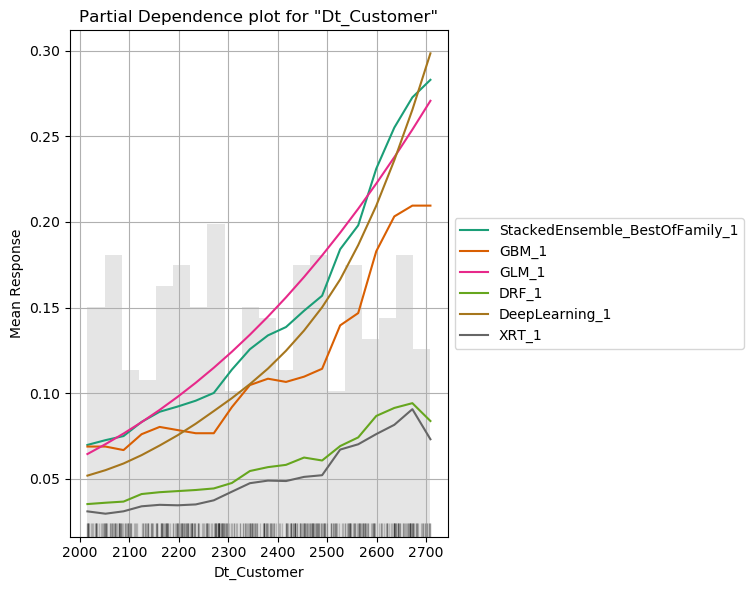

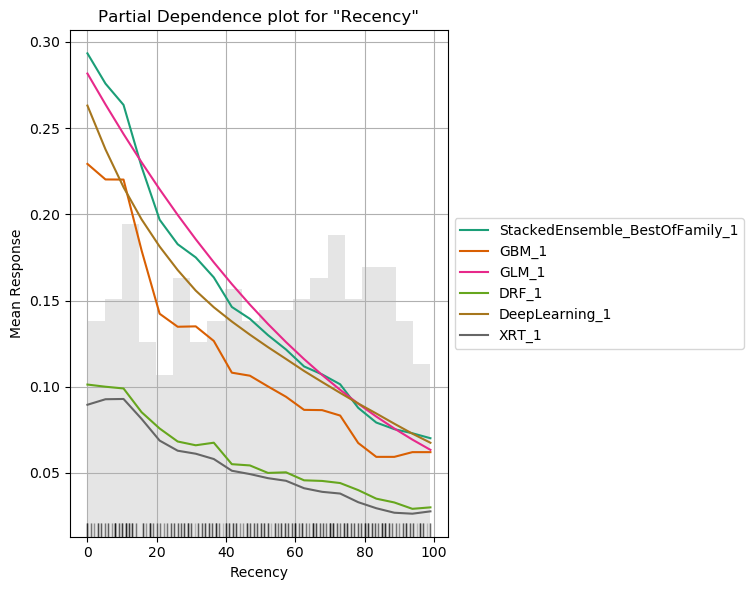

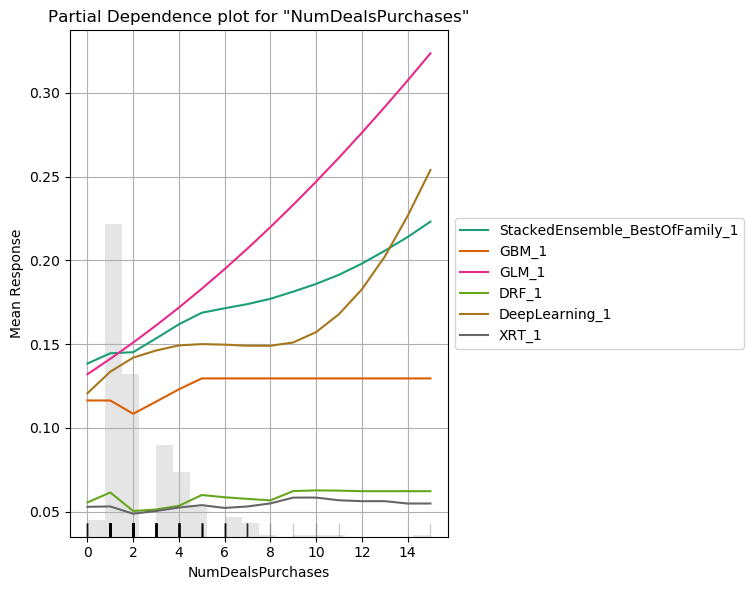

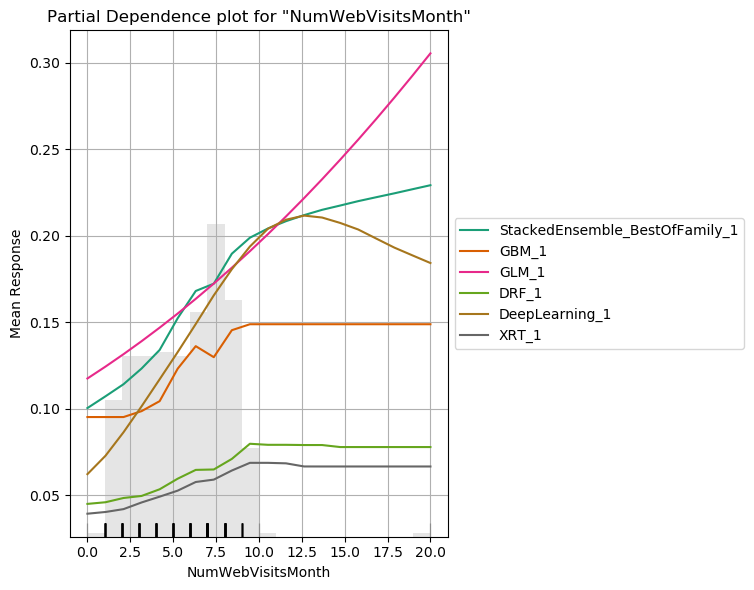

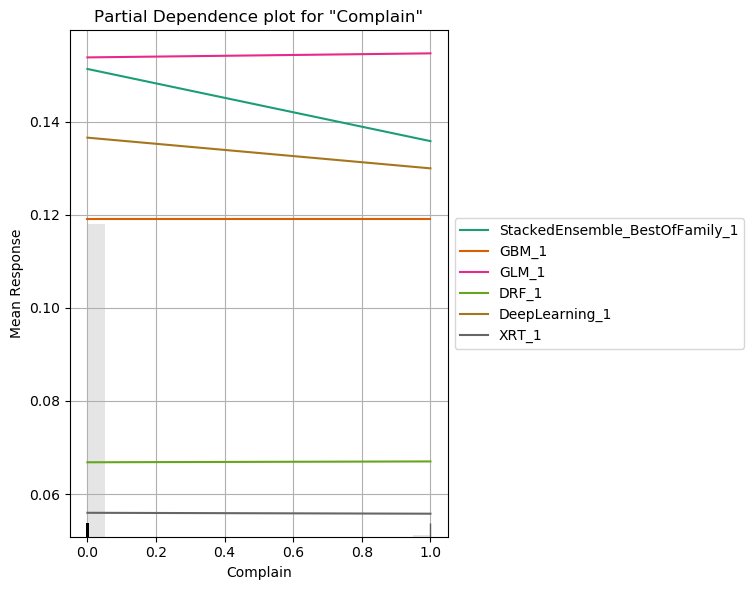

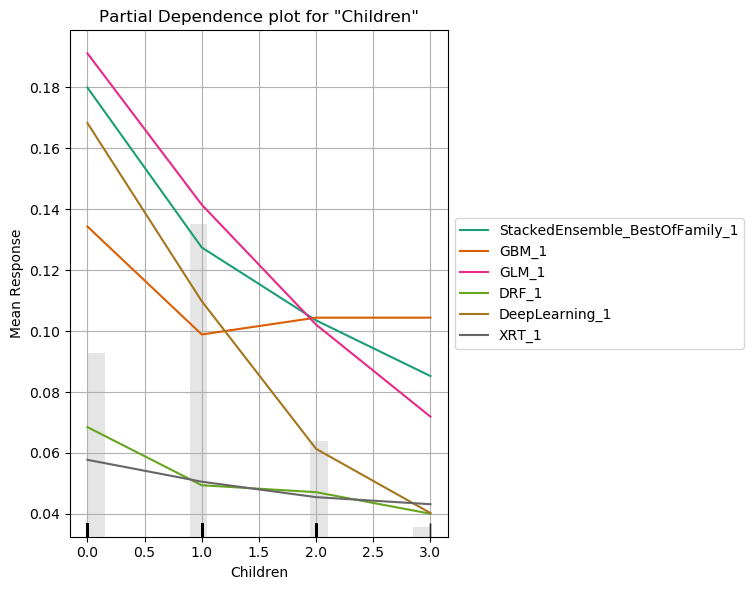

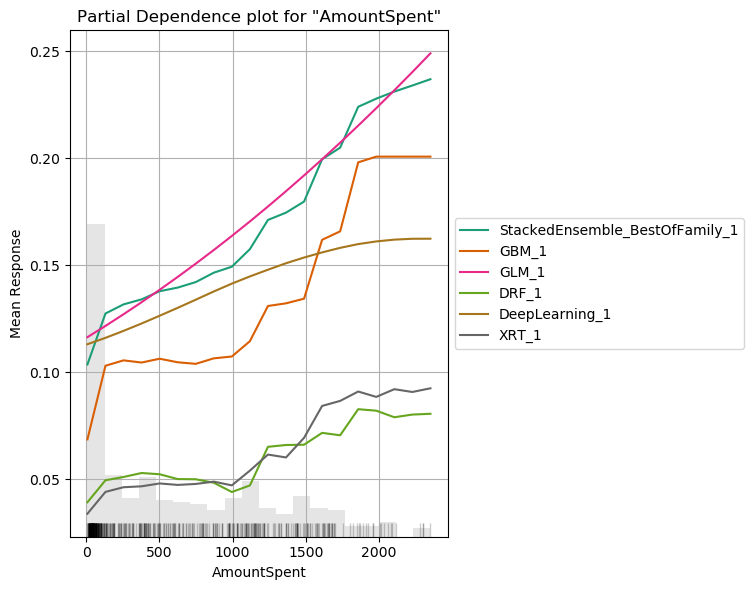

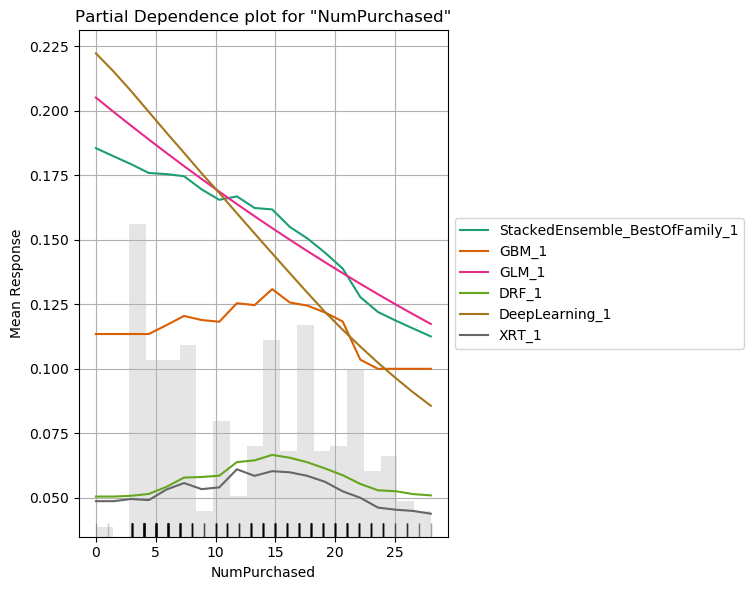

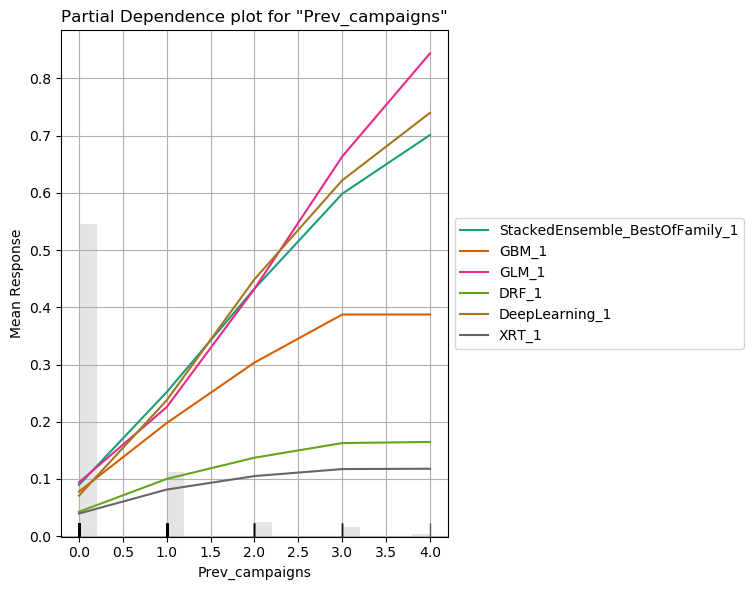

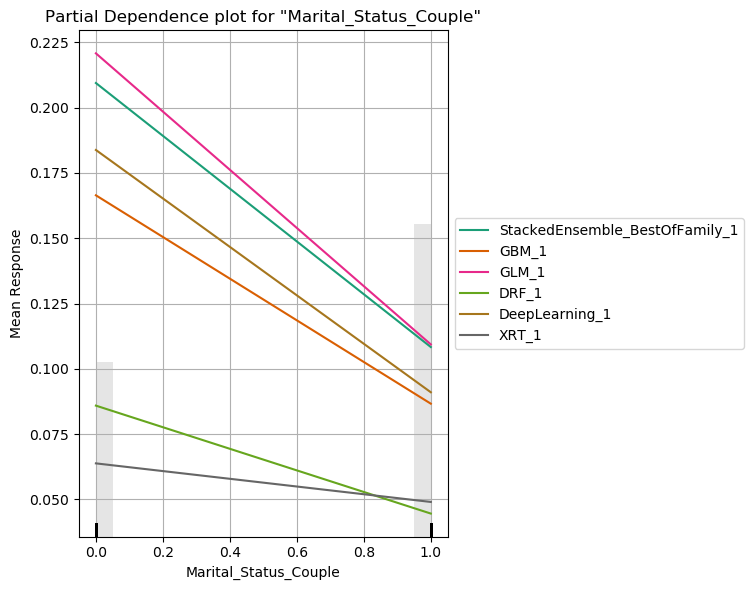

In [61]:
explain_model = aml.explain(frame = test, figsize = (8,6),include_explanations=['pdp'])


## Interpreting Partial Dependency Plots

The pdp shows us the effect of each feature on prediction.

Prev_campaign has a high linear dependency while compain has no effect on prediction

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id                                                      auc    logloss     aucpr    mean_per_class_error      rmse        mse    training_time_ms    predict_time_per_row_ms  algo
-------------------------------------------------------  --------  ---------  --------  ----------------------  --------  ---------  ------------------  -------------------------  ---------------
GBM_1_AutoML_7_20230329_201233                           0.904153   0.297101  0.692138                0.174469  0.306446  0.0939089                 238                   0.019383  GBM
StackedEnsemble_BestOfFamily_1_AutoML_7_20230329_201233  0.90378    0.280322  0.700942                0.170596  0.293808  0.0863233                 868                   0.023789  StackedEnsemble
StackedEnsemble_AllModels_1_AutoML_7_20230329_201233     0.903594   0.280831  0.700987                0.170596  0.294146  0.0865217                 873                   0.043632  StackedEnsemble
GBM_3_AutoML_7_20230329_201233                           0.900968   0.334679  0.690449                0.205773  0.324805  0.105499                   92                   0.012005  GBM
GBM_2_AutoML_7_20230329_201233                           0.900503   0.338769  0.685194                0.201583  0.327407  0.107195                   94                   0.019824  GBM
GLM_1_AutoML_7_20230329_201233                           0.890968   0.293114  0.677646                0.173389  0.299829  0.0898975                  34                   0.007172  GLM
GBM_4_AutoML_7_20230329_201233                           0.888045   0.367863  0.629228                0.219423  0.339515  0.11527                   106                   0.013199  GBM
DRF_1_AutoML_7_20230329_201233                           0.887821   0.609673  0.618866                0.174469  0.35311   0.124687                  199                   0.017619  DRF
XRT_1_AutoML_7_20230329_201233                           0.885121   0.480372  0.595675                0.180372  0.360562  0.130005                  243                   0.018732  DRF
GBM_5_AutoML_7_20230329_201233                           0.877412   0.351217  0.646528                0.266536  0.33015   0.108999                   86                   0.011814  GBM
GBM_grid_1_AutoML_7_20230329_201233_model_1              0.860335   0.390988  0.611441                0.213259  0.347234  0.120572                  123                   0.014048  GBM
DeepLearning_1_AutoML_7_20230329_201233                  0.850093   0.361659  0.616826                0.240819  0.322593  0.104066                   64                   0.008566  DeepLearning
[12 rows x 10 columns]

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_BestOfFamily_1_AutoML_7_20230329_201233

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22320420839468122
       0    1    Error    Rate
-----  ---  ---  -------  ------------
0      317  41   0.1145   (41.0/358.0)
1      17   58   0.2267   (17.0/75.0)
Total  334  99   0.1339   (58.0/433.0)

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

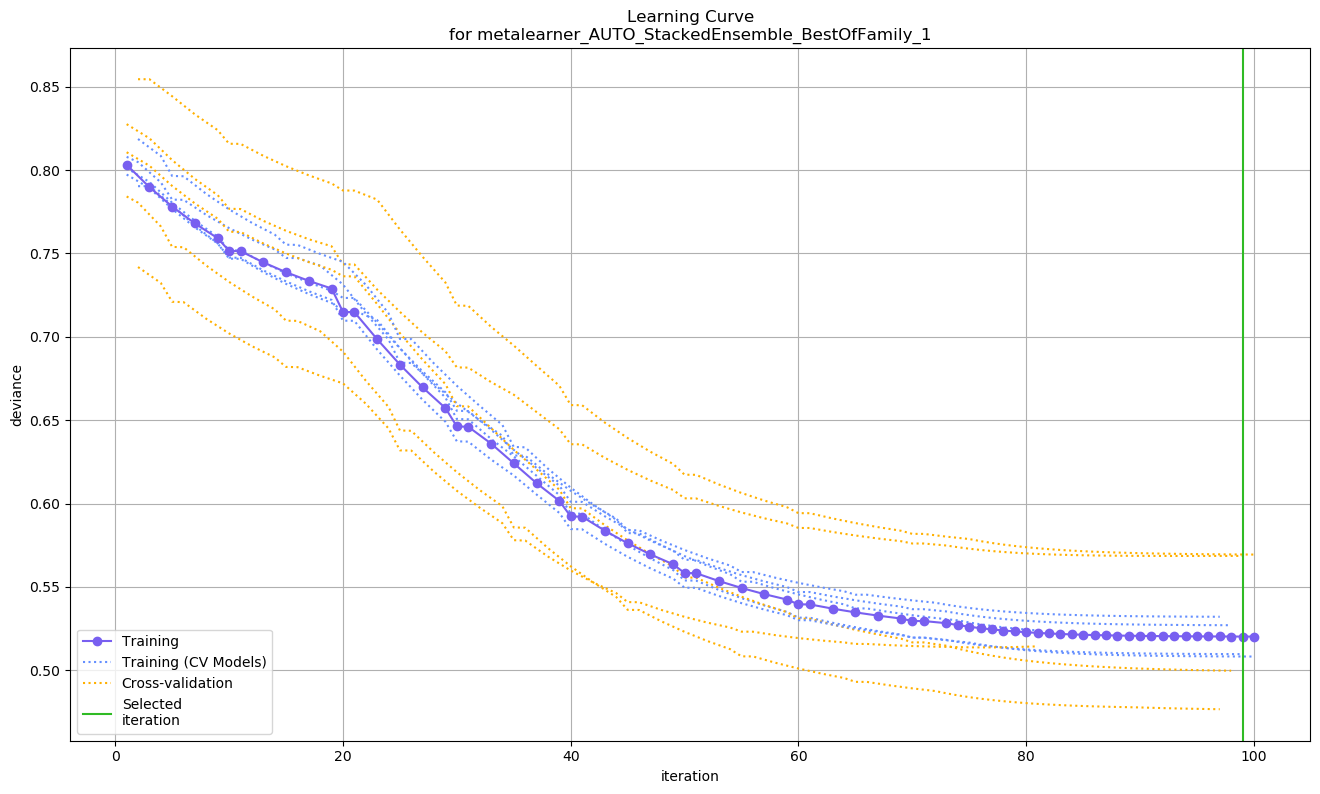

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

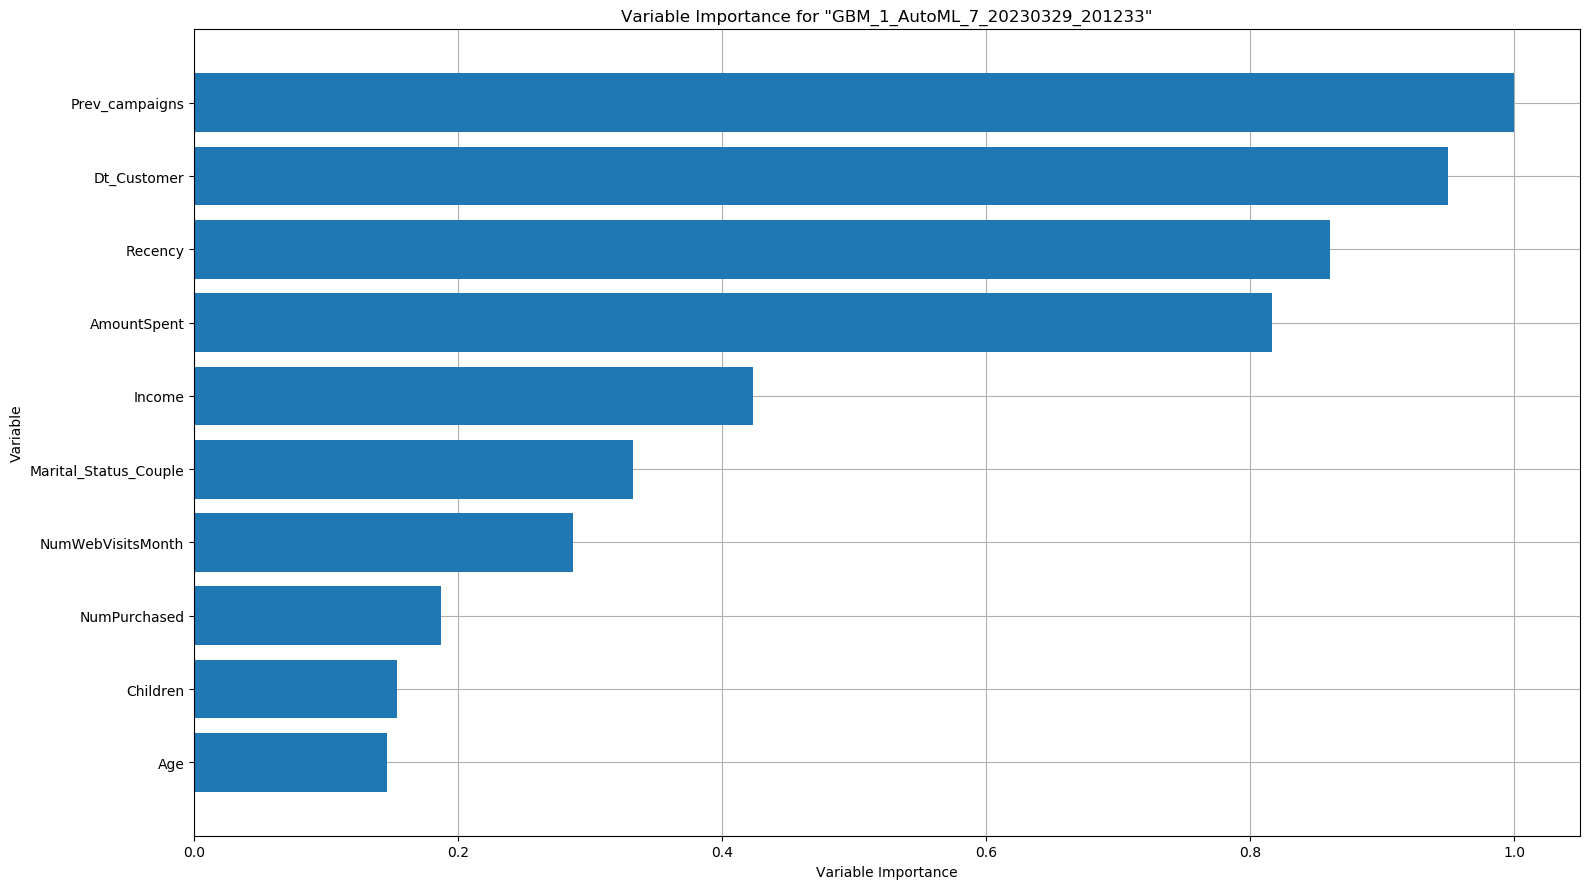

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

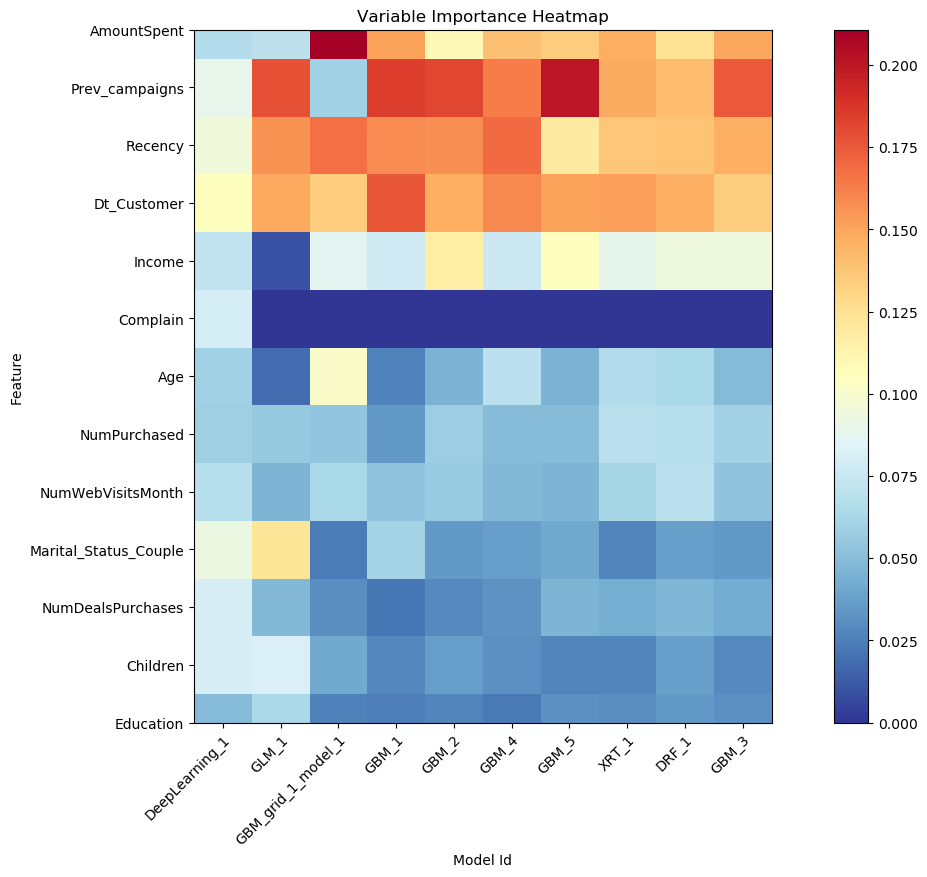

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

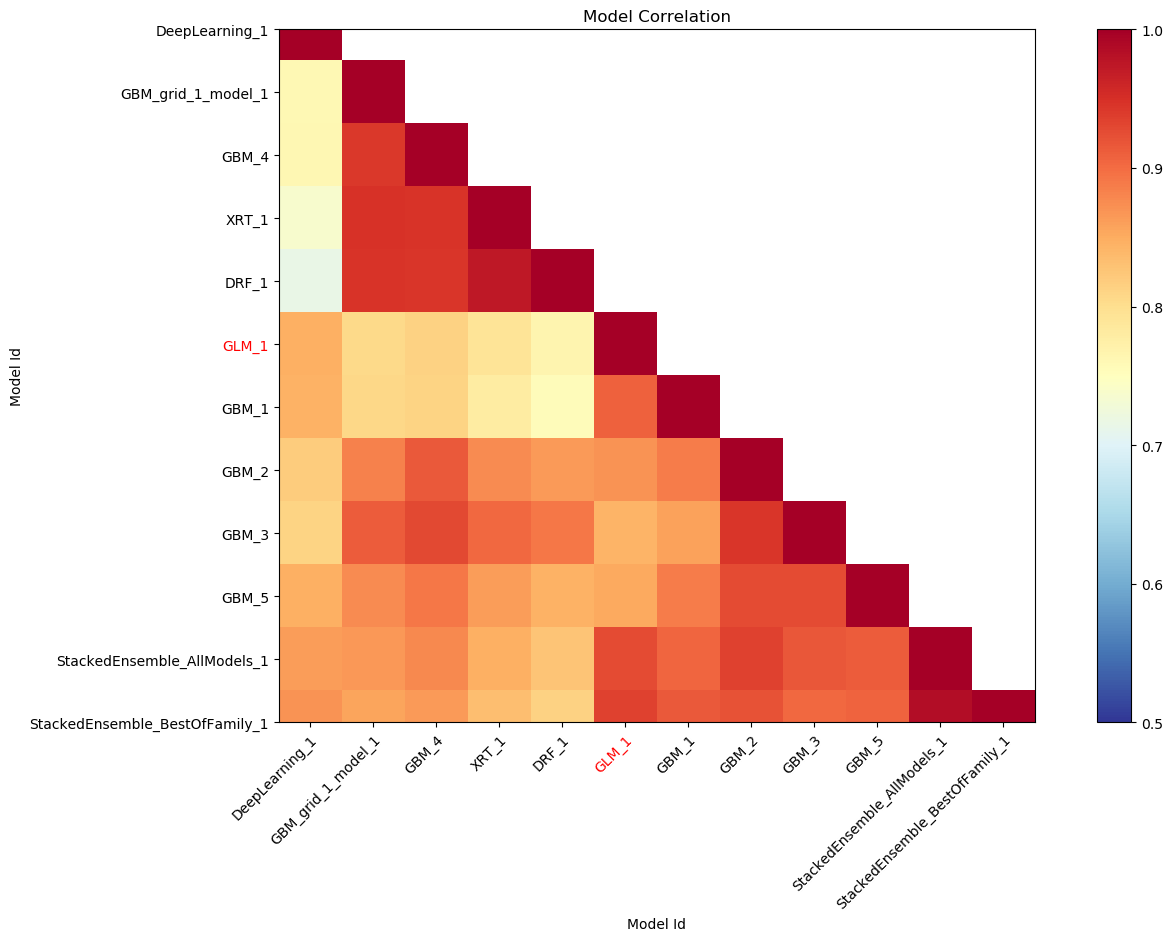

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

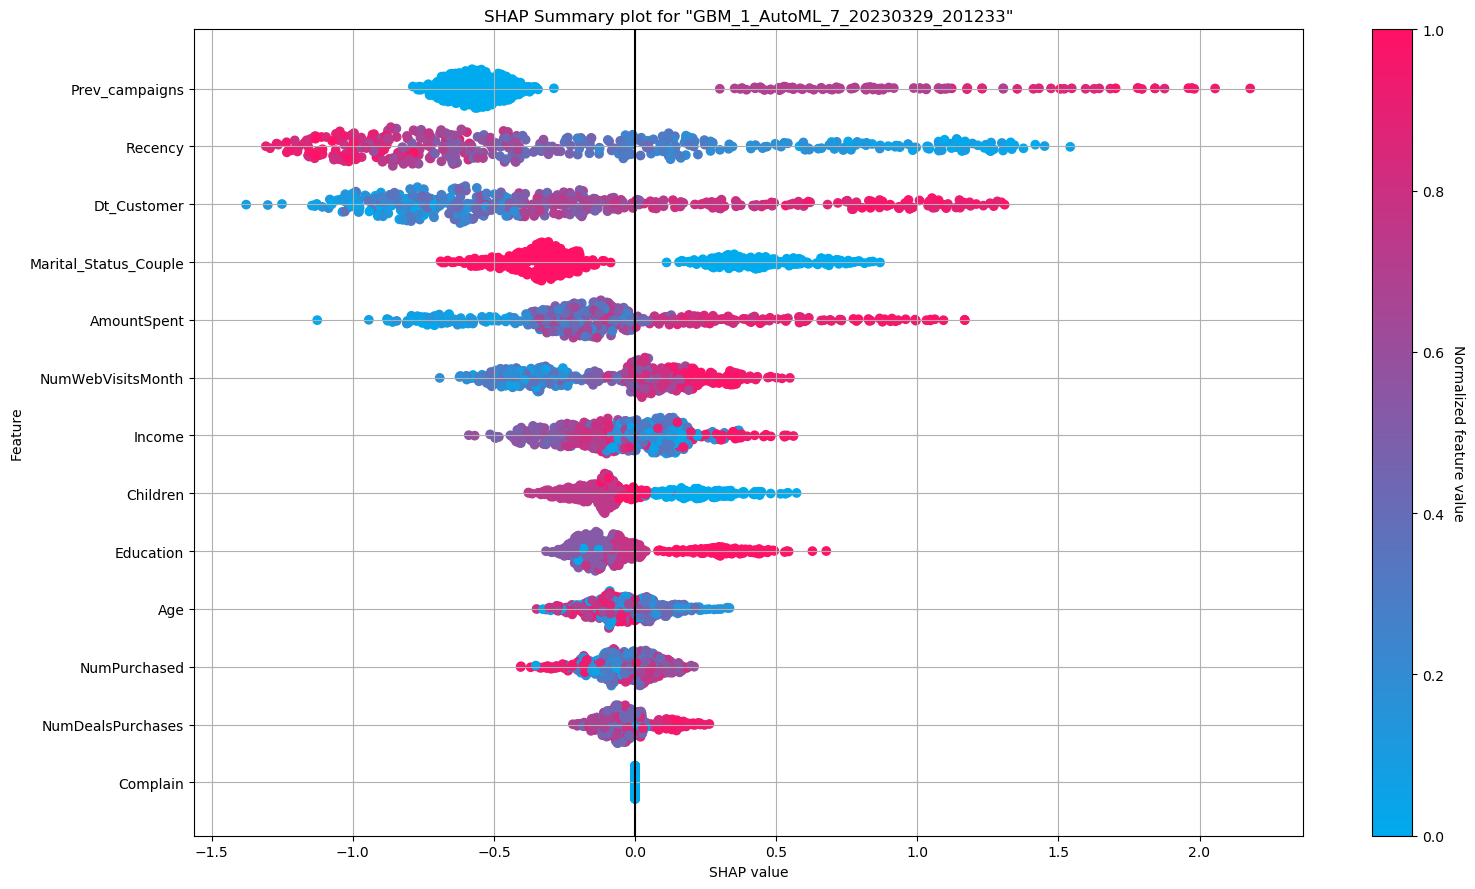

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

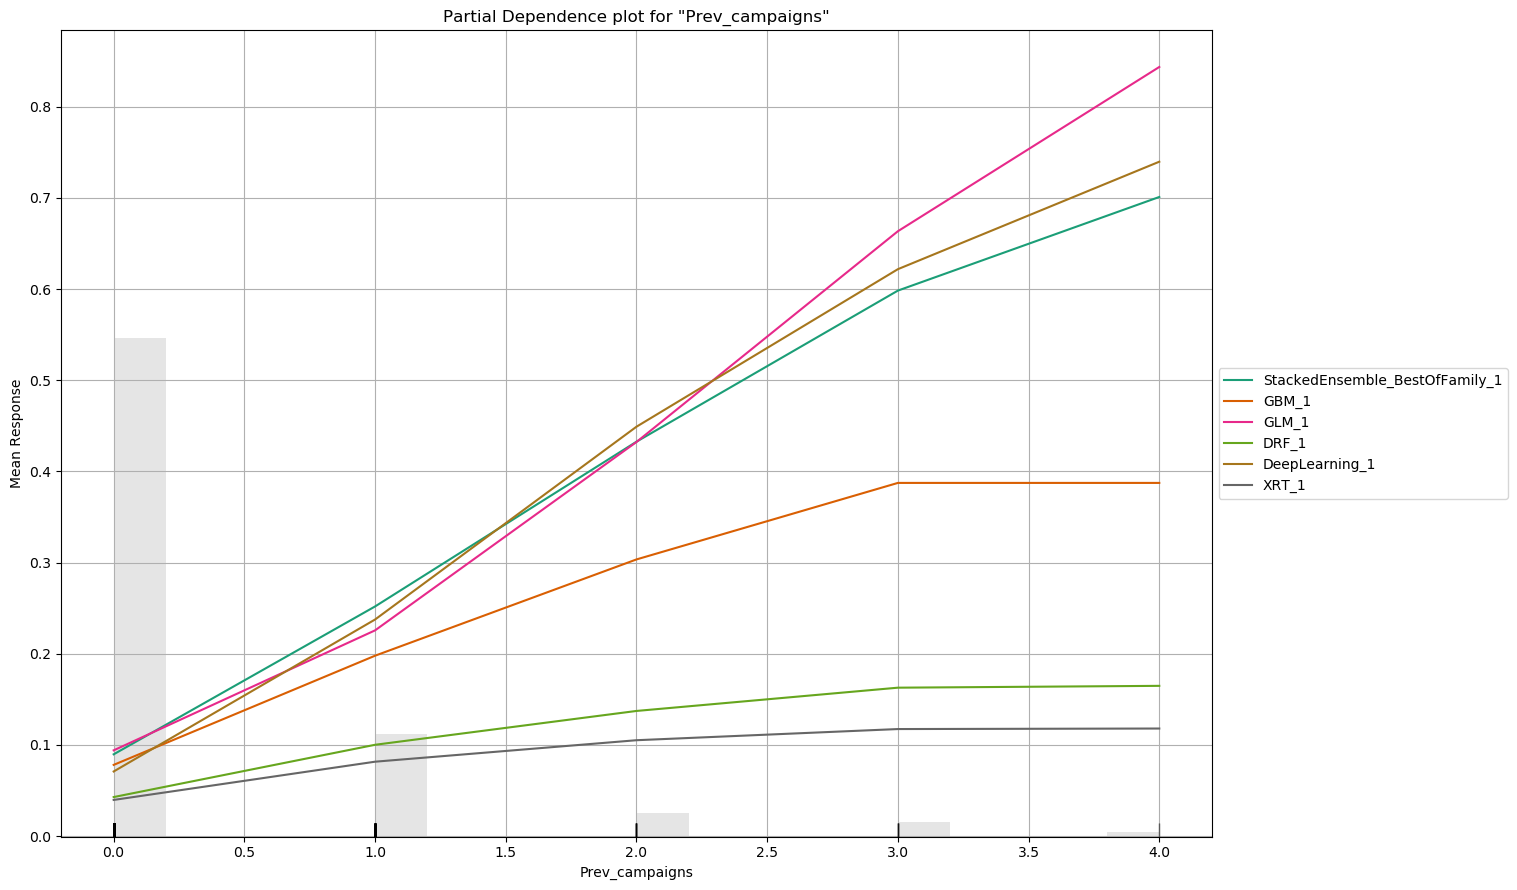

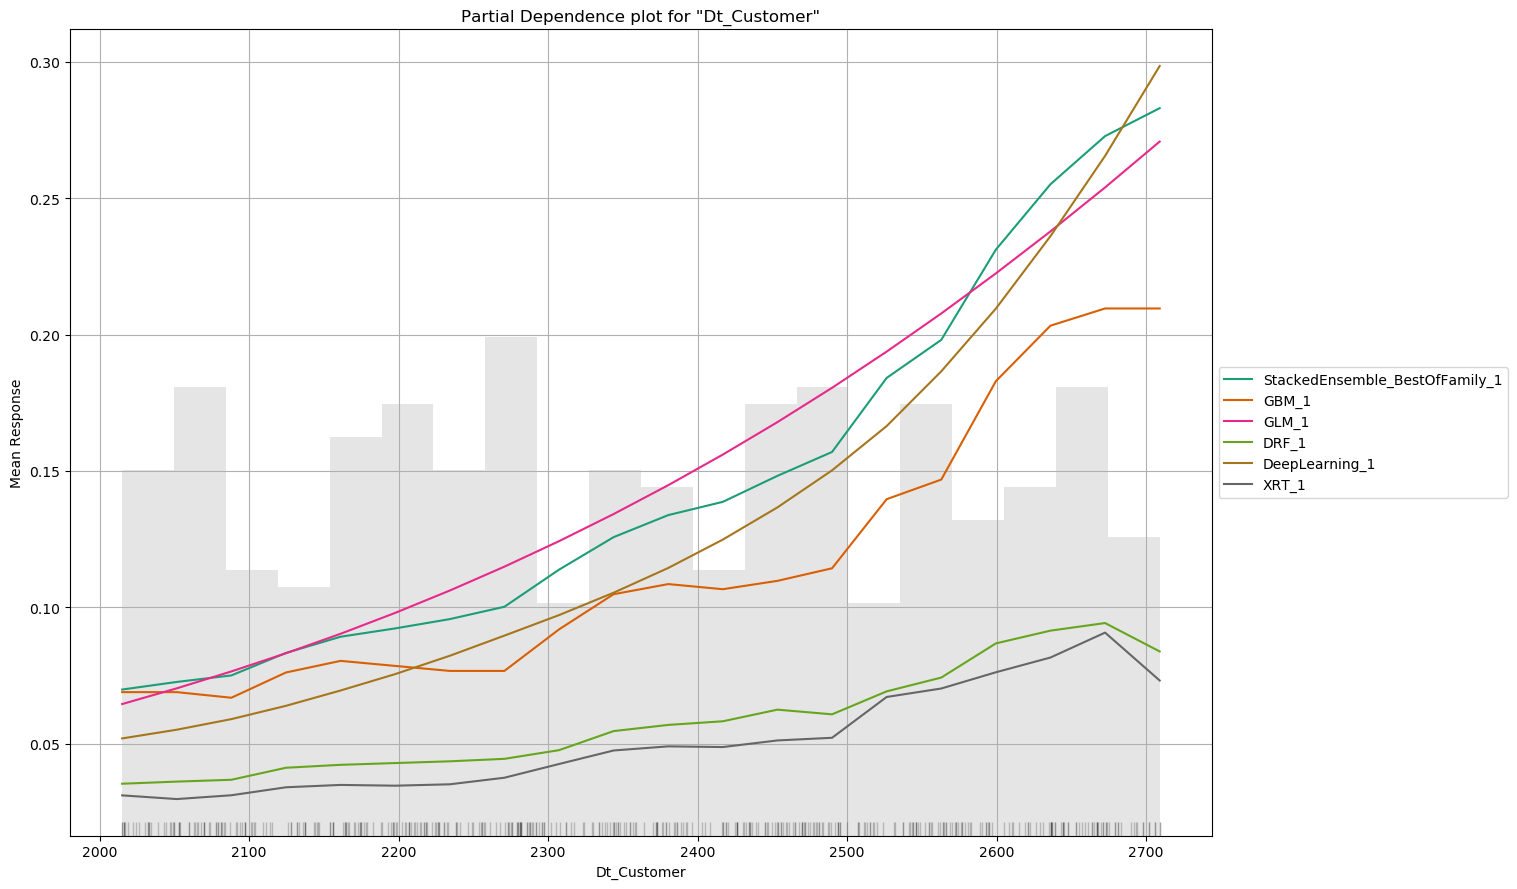

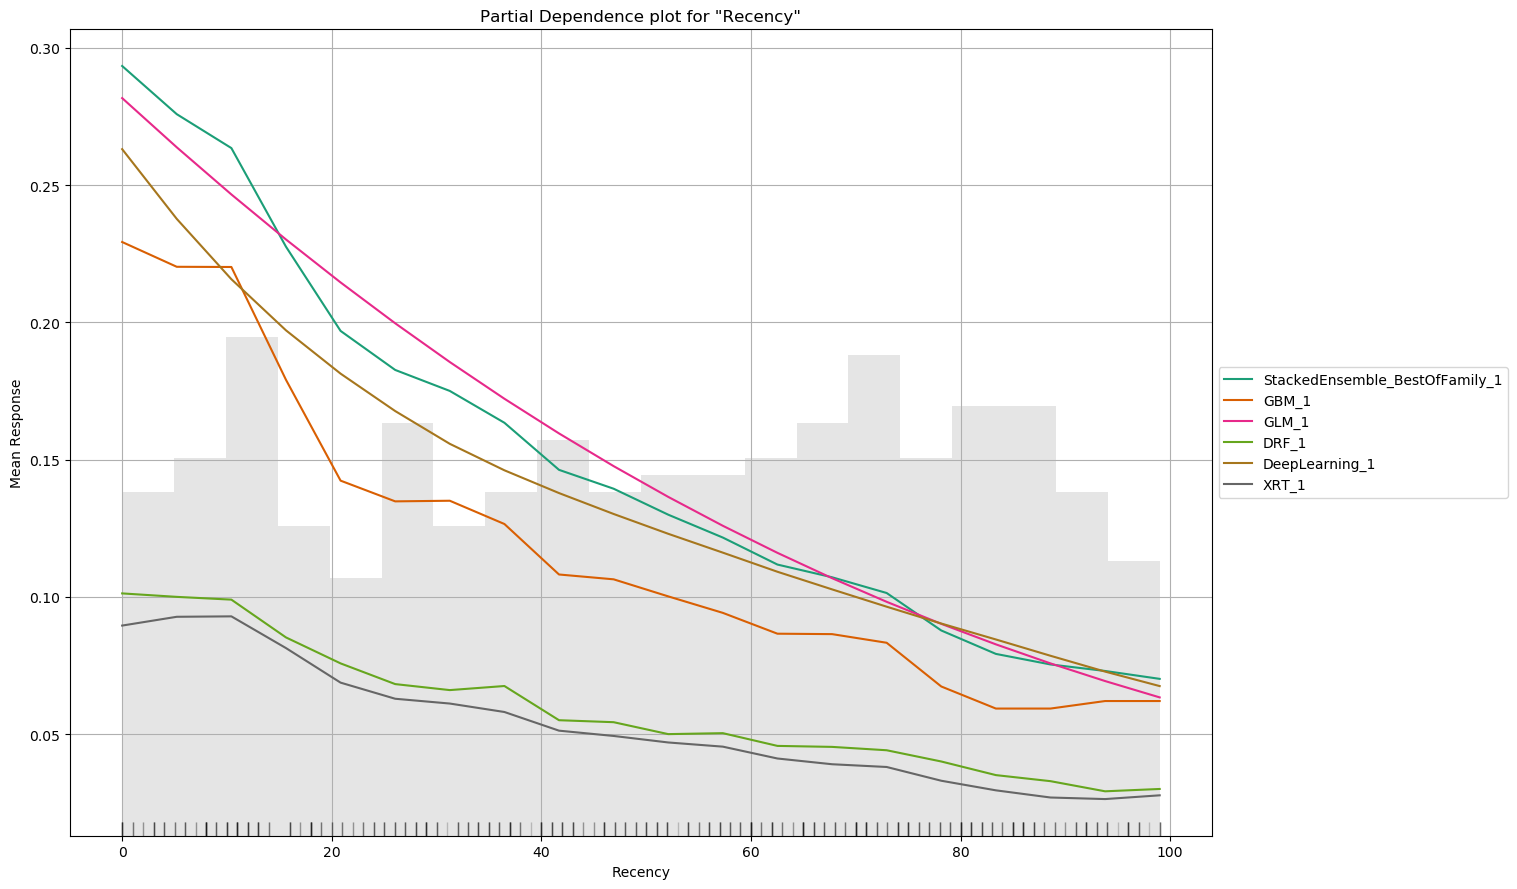

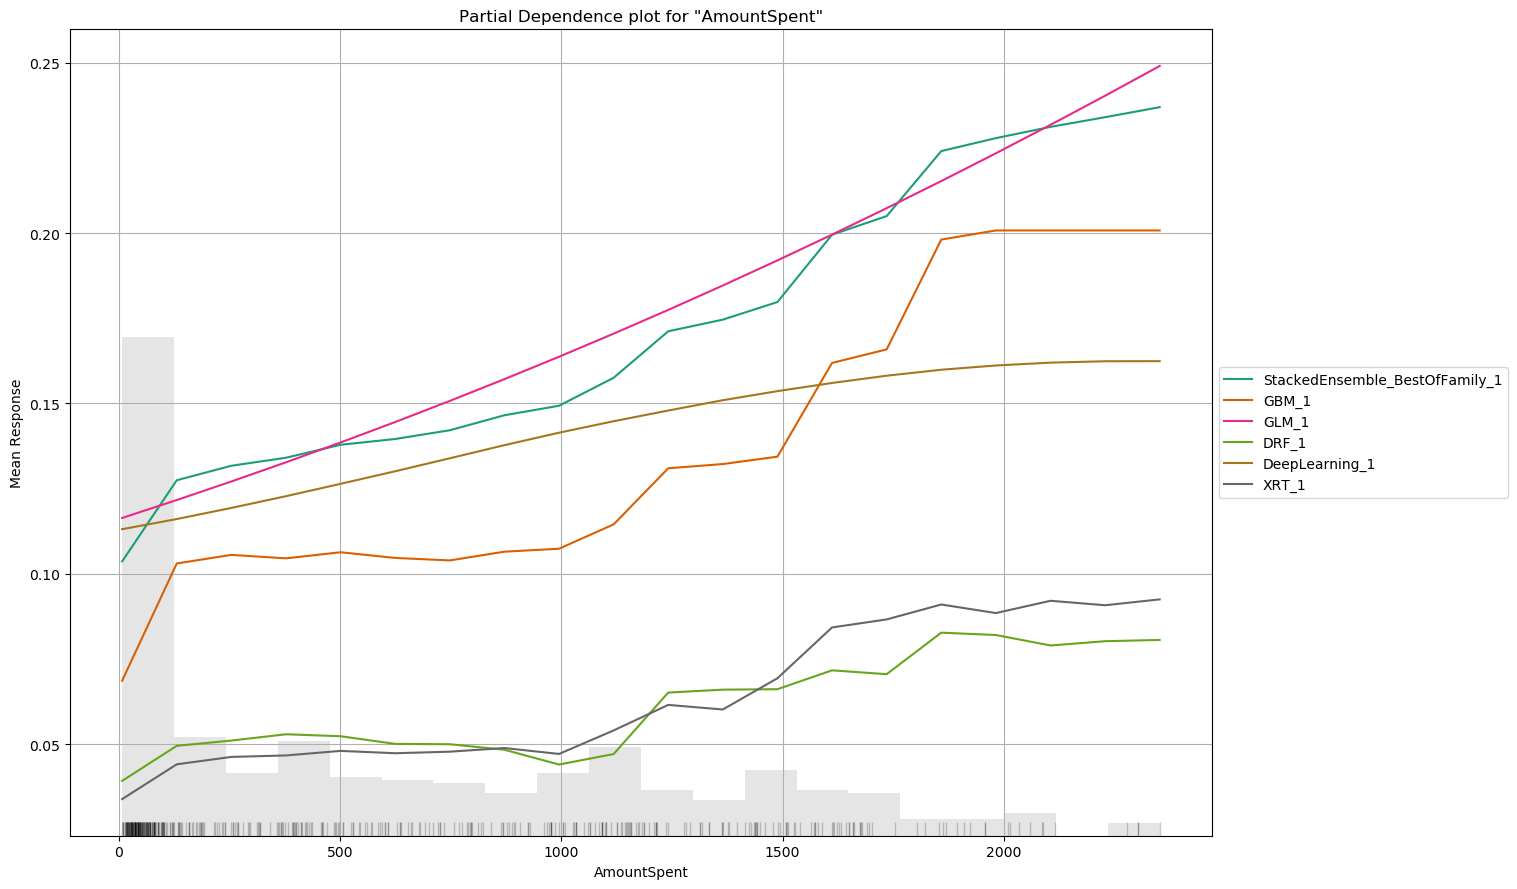

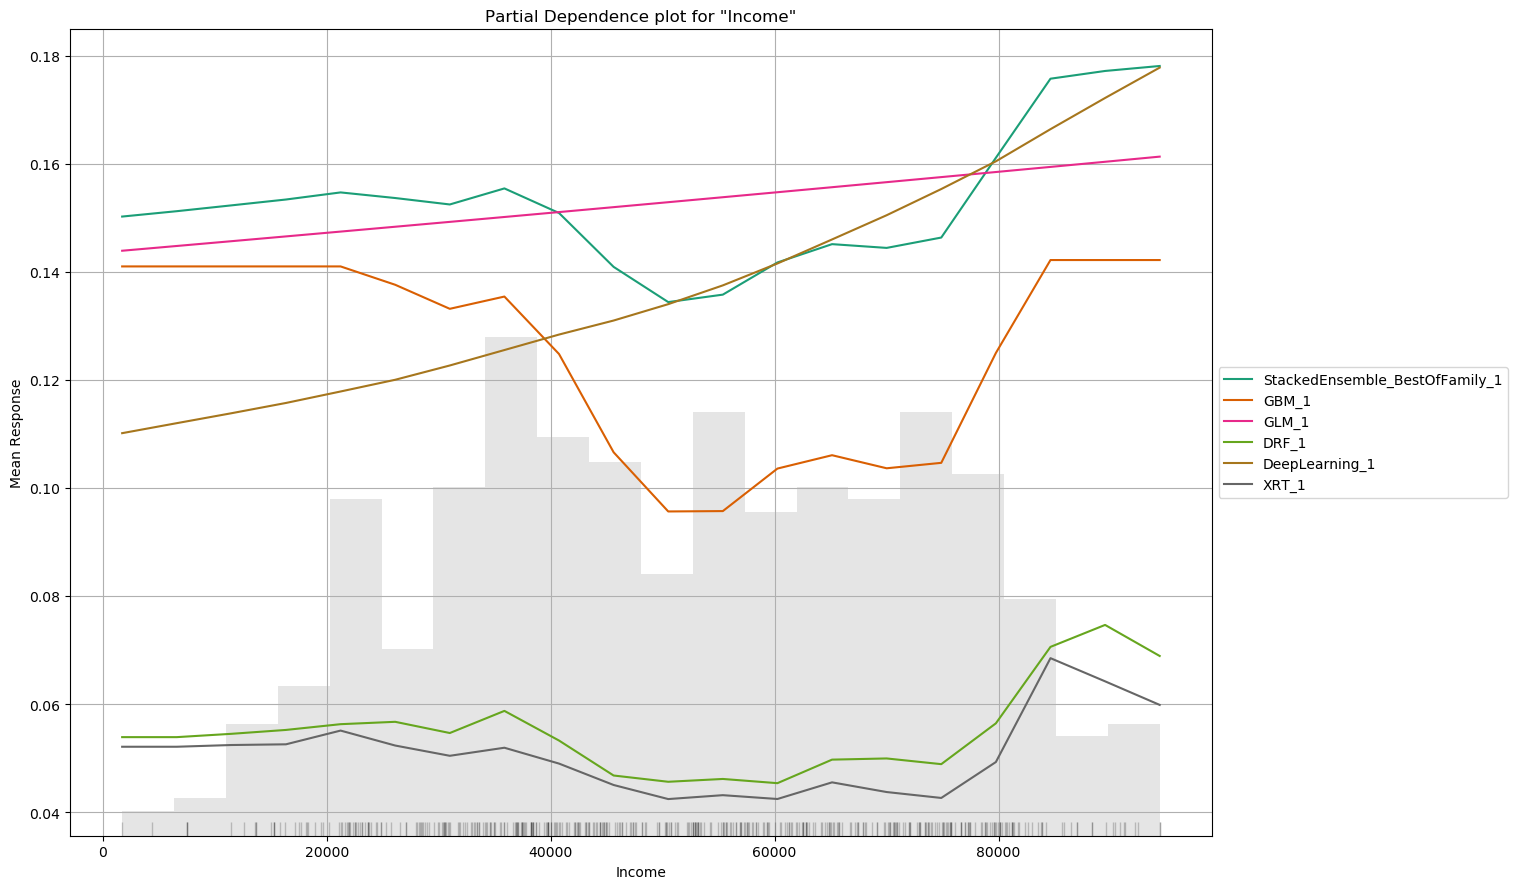

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id                                                      auc    logloss     aucpr    mean_per_class_error      rmse        mse    training_time_ms    predict_time_per_row_ms  algo
-------------------------------------------------------  --------  ---------  --------  ----------------------  --------  ---------  ------------------  -------------------------  ---------------
GBM_1_AutoML_7_20230329_201233                           0.904153   0.297101  0.692138                0.174469  0.306446  0.0939089                 238                   0.019383  GBM
StackedEnsemble_BestOfFamily_1_AutoML_7_20230329_201233  0.90378    0.280322  0.700942                0.170596  0.293808  0.0863233                 868                   0.023789  StackedEnsemble
StackedEnsemble_AllModels_1_AutoML_7_20230329_201233     0.903594   0.280831  0.700987                0.170596  0.294146  0.0865217                 873                   0.043632  StackedEnsemble
GBM_3_AutoML_7_20230329_201233                           0.900968   0.334679  0.690449                0.205773  0.324805  0.105499                   92                   0.012005  GBM
GBM_2_AutoML_7_20230329_201233                           0.900503   0.338769  0.685194                0.201583  0.327407  0.107195                   94                   0.019824  GBM
GLM_1_AutoML_7_20230329_201233                           0.890968   0.293114  0.677646                0.173389  0.299829  0.0898975                  34                   0.007172  GLM
GBM_4_AutoML_7_20230329_201233                           0.888045   0.367863  0.629228                0.219423  0.339515  0.11527                   106                   0.013199  GBM
DRF_1_AutoML_7_20230329_201233                           0.887821   0.609673  0.618866                0.174469  0.35311   0.124687                  199                   0.017619  DRF
XRT_1_AutoML_7_20230329_201233                           0.885121   0.480372  0.595675                0.180372  0.360562  0.130005                  243                   0.018732  DRF
GBM_5_AutoML_7_20230329_201233                           0.877412   0.351217  0.646528                0.266536  0.33015   0.108999                   86                   0.011814  GBM
GBM_grid_1_AutoML_7_20230329_201233_model_1              0.860335   0.390988  0.611441                0.213259  0.347234  0.120572                  123                   0.014048  GBM
DeepLearning_1_AutoML_7_20230329_201233                  0.850093   0.361659  0.616826                0.240819  0.322593  0.104066                   64                   0.008566  DeepLearning
[12 rows x 10 columns]

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_BestOfFamily_1_AutoML_7_20230329_201233

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22320420839468122
       0    1    Error    Rate
-----  ---  ---  -------  ------------
0      317  41   0.1145   (41.0/358.0)
1      17   58   0.2267   (17.0/75.0)
Total  334  99   0.1339   (58.0/433.0)

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

In [62]:
aml.explain(test)

# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

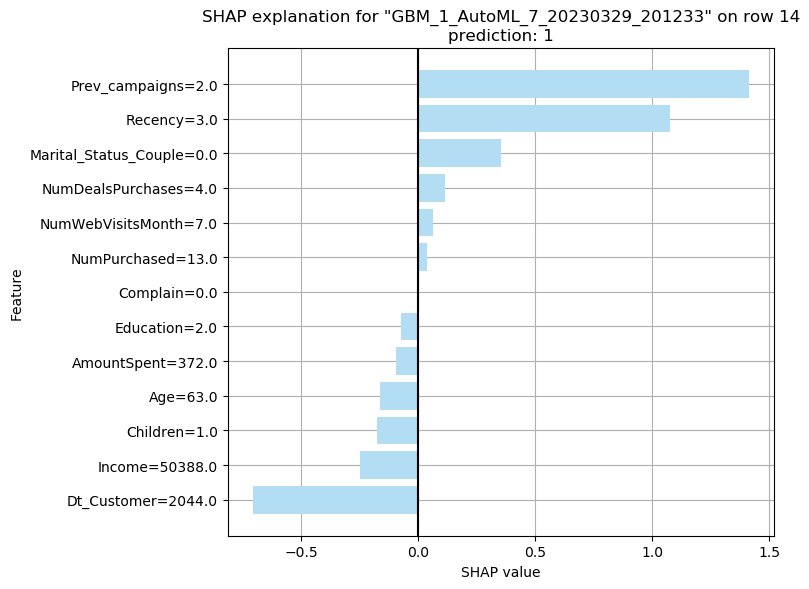

# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

In [63]:
aml.explain_row(frame = test, row_index = 14, figsize = (8,6), exclude_explanations = "leaderboard")


# SHAP Analysis for Linear and Tree-Based Models


Permutation explainer: 1774it [00:47, 27.08it/s]                                


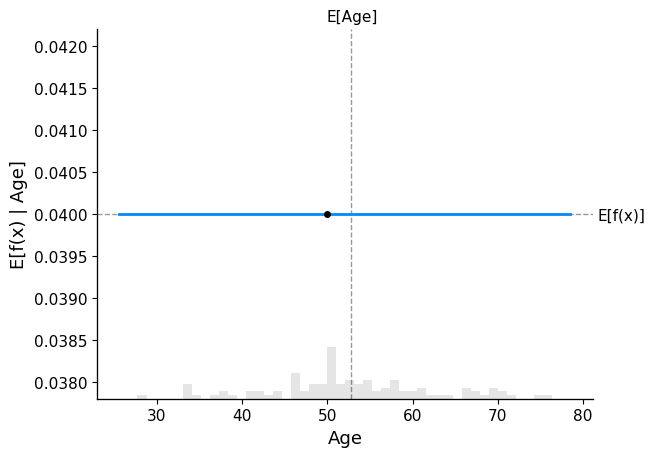

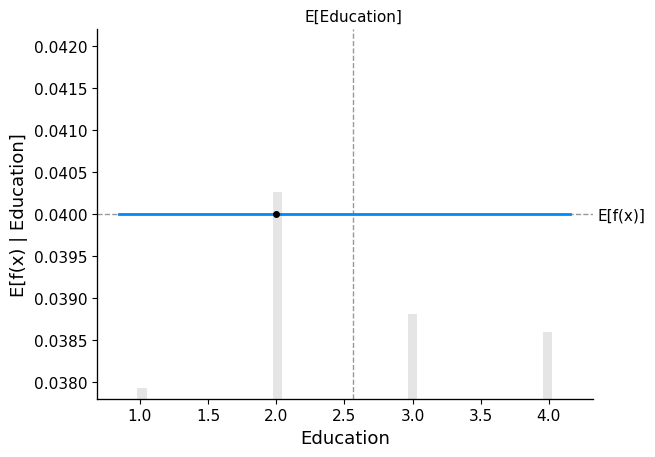

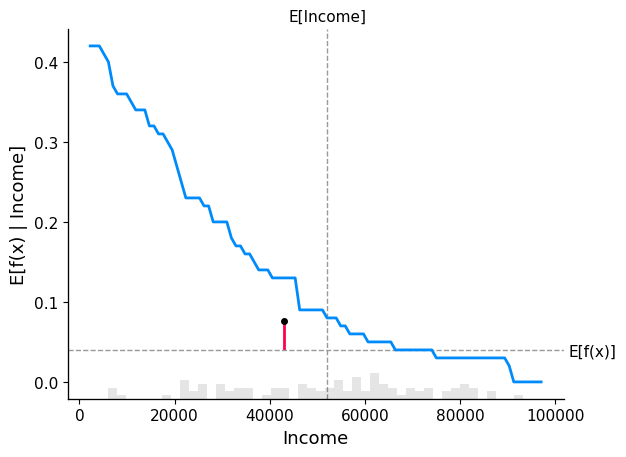

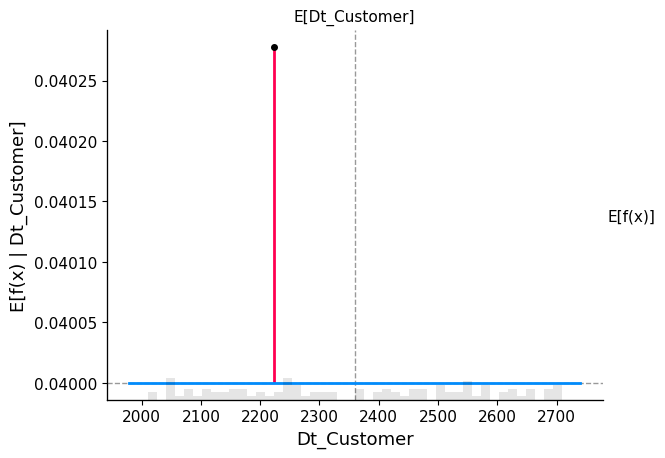

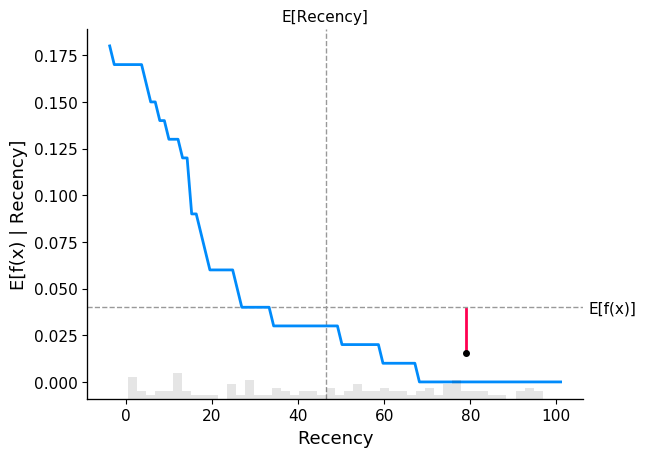

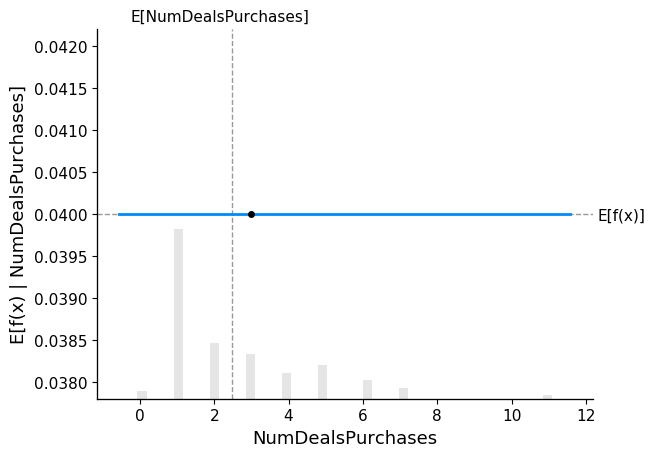

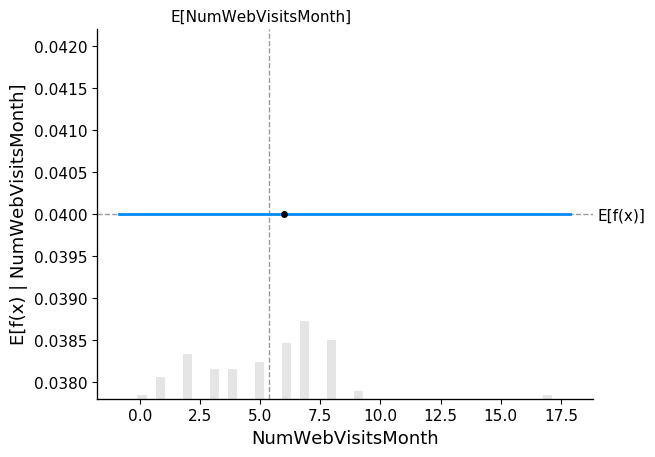

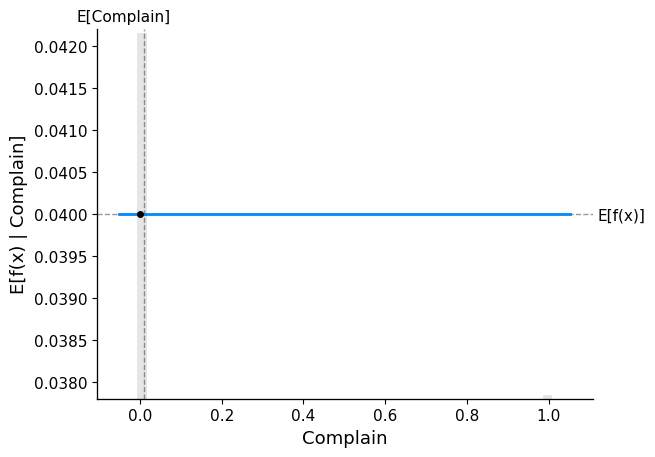

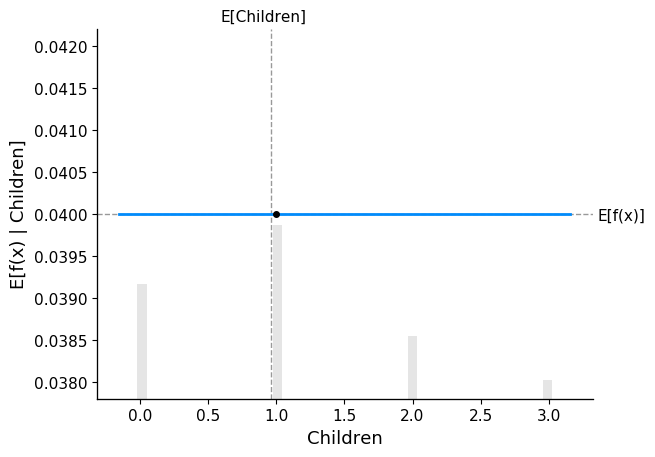

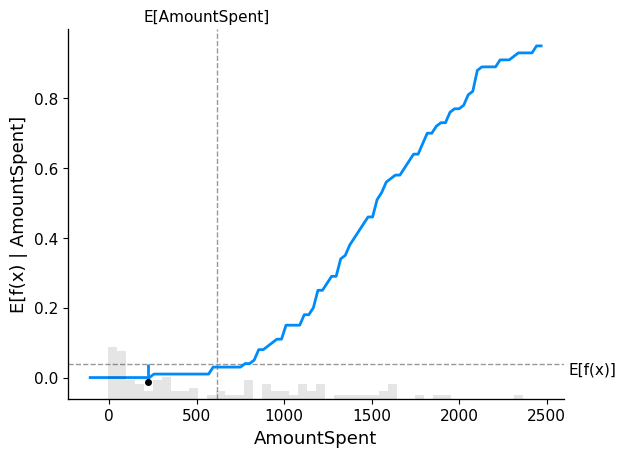

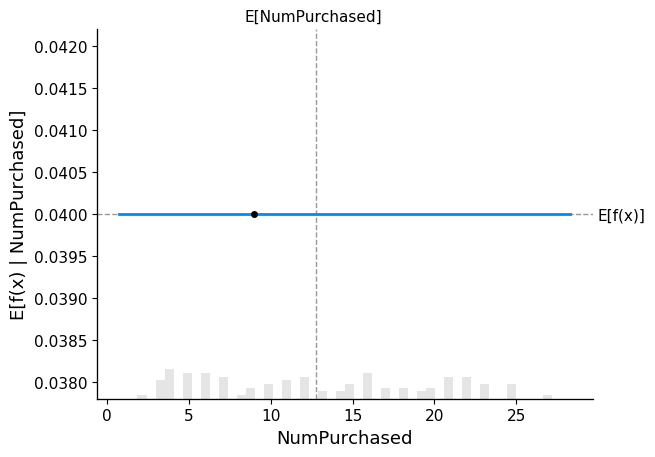

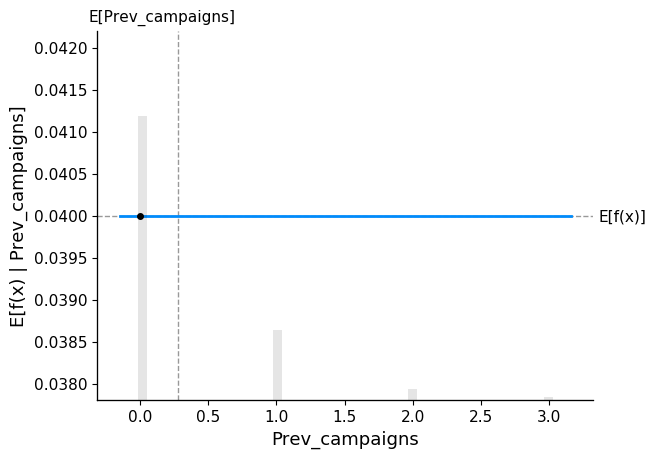

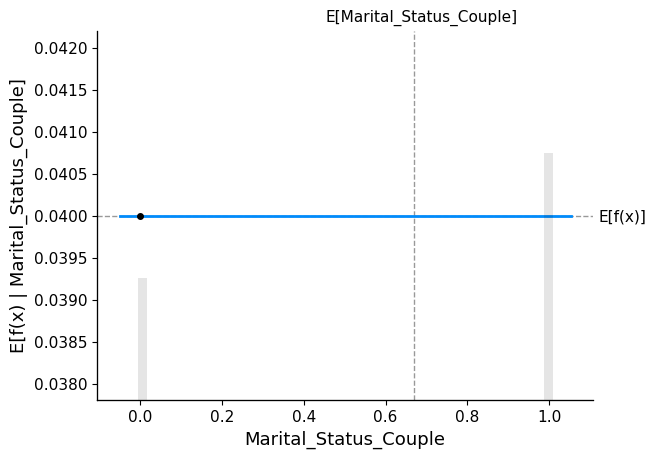

In [64]:
import shap
# SHAP explanation of a Linear Model

x_train_100 = shap.utils.sample(
    x_train, 100
)  # Taking 100 samples out for SHAP analysis as it is a computationally expensive process
x_test_100 = shap.utils.sample(
    x_test, 100
) 

linear_explainer = shap.Explainer(logreg.predict, x_train_100)
linear_shap_values = linear_explainer(x_train)
for i in x_train.columns:
    # make a standard partial dependence plot
    sample_ind = 18
    shap.partial_dependence_plot(
        i,
        logreg.predict,
        x_train_100,
        model_expected_value=True,
        feature_expected_value=True,
        ice=False,
        shap_values=linear_shap_values[sample_ind : sample_ind + 1, :],
    )
     

Permutation explainer: 1774it [00:16, 43.21it/s]                                


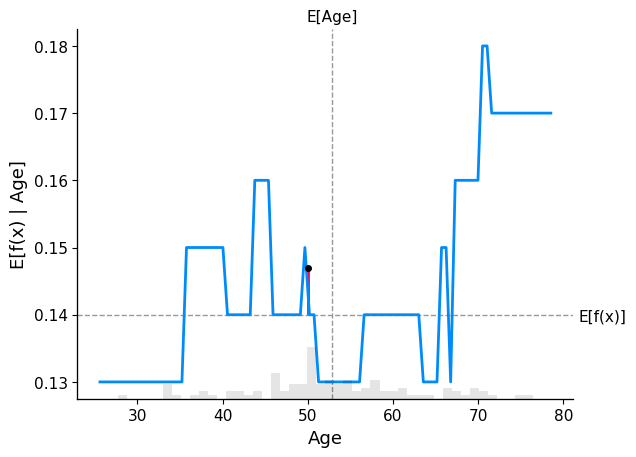

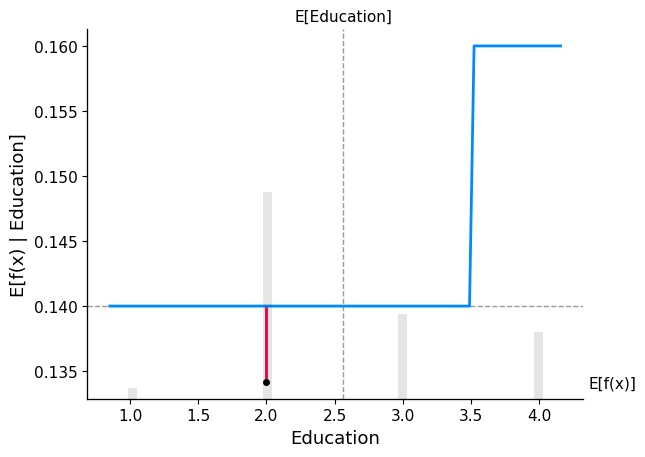

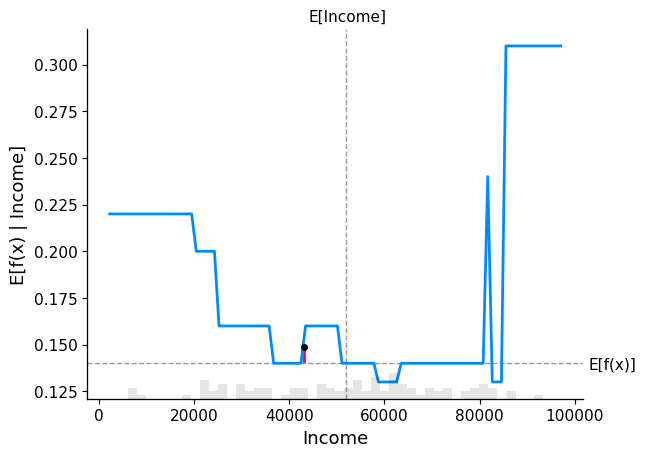

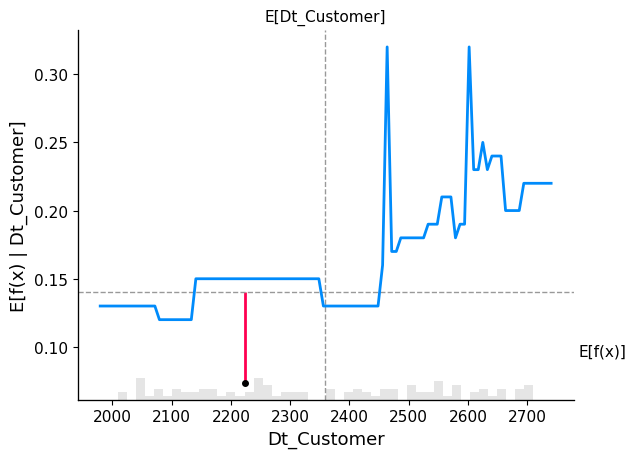

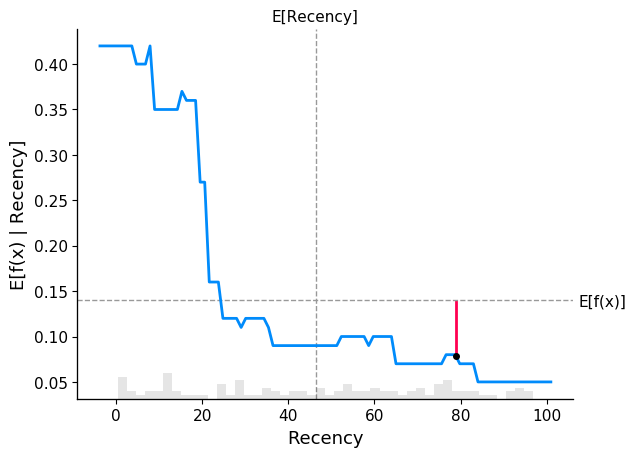

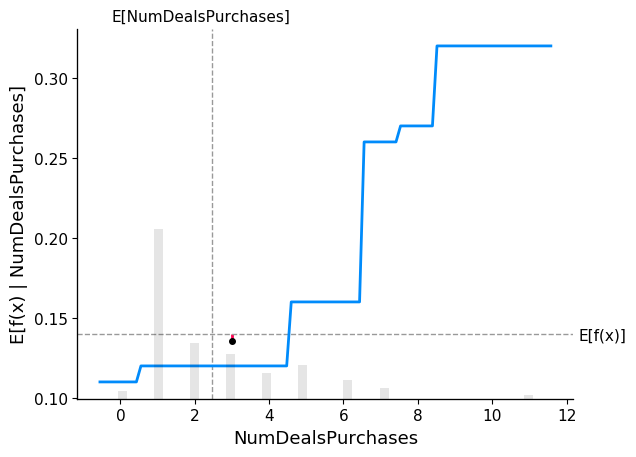

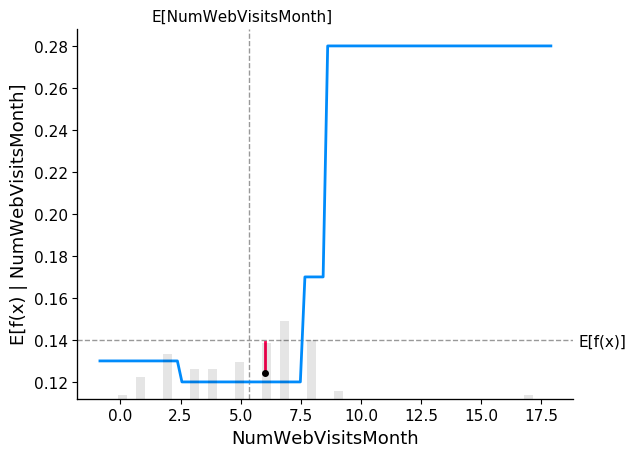

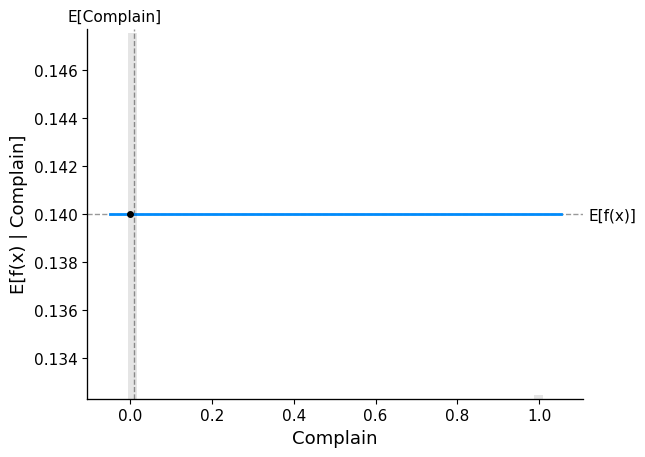

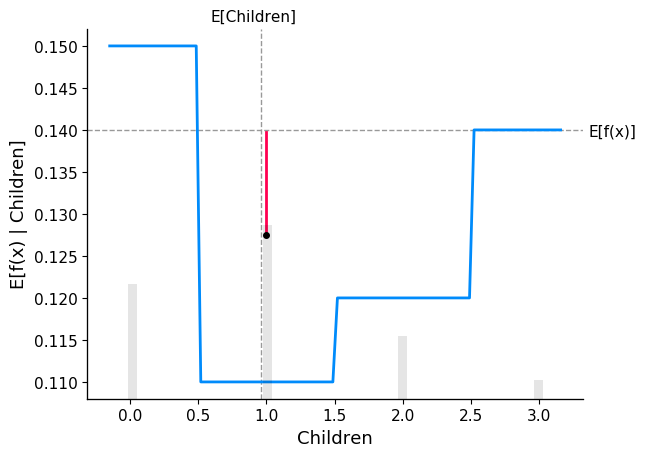

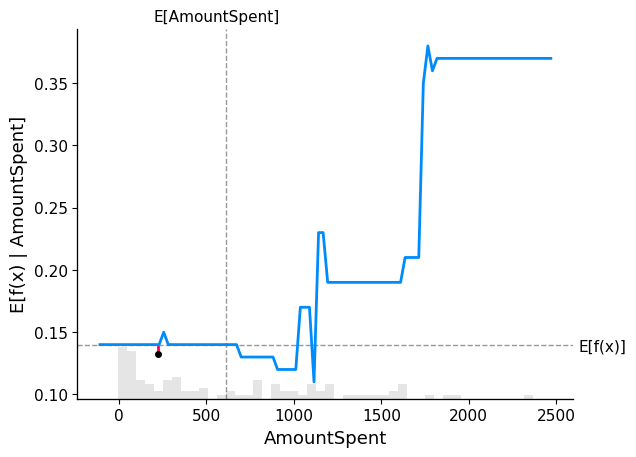

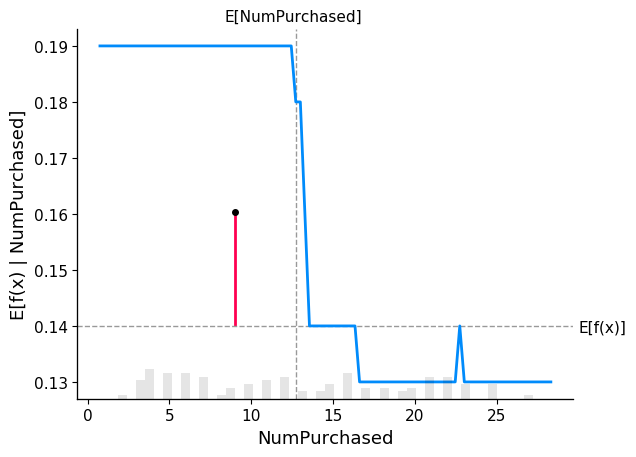

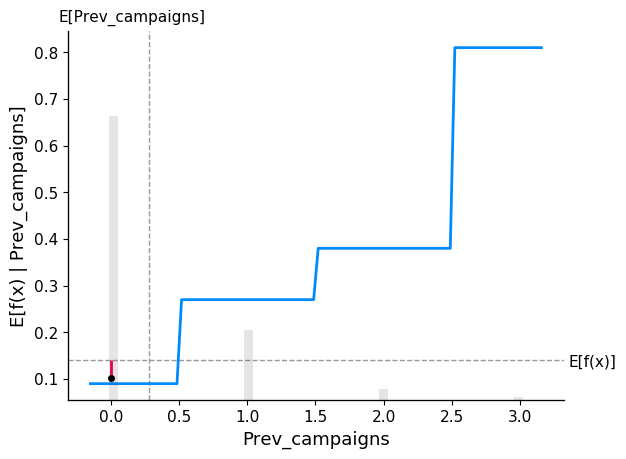

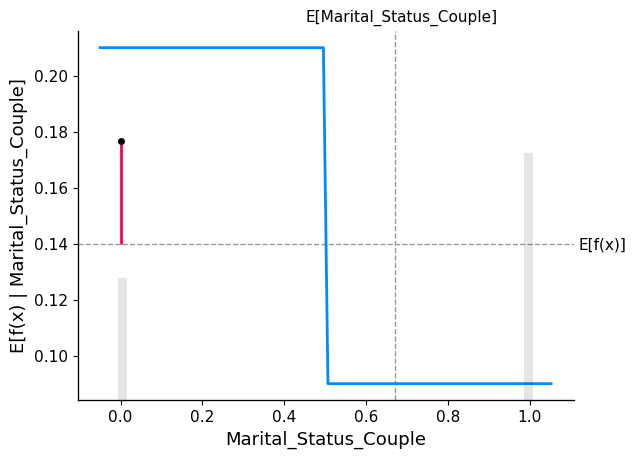

In [65]:
# SHAP explanation of a tree based model
tree_explainer = shap.Explainer(dtc.predict, x_train_100)
tree_shap_values = tree_explainer(x_train)
for i in x_train.columns:
    # make a standard partial dependence plot
    sample_ind = 18
    shap.partial_dependence_plot(
        i,
        dtc.predict,
        x_train_100,
        model_expected_value=True,
        feature_expected_value=True,
        ice=False,
        shap_values=tree_shap_values[sample_ind : sample_ind + 1, :],
    )

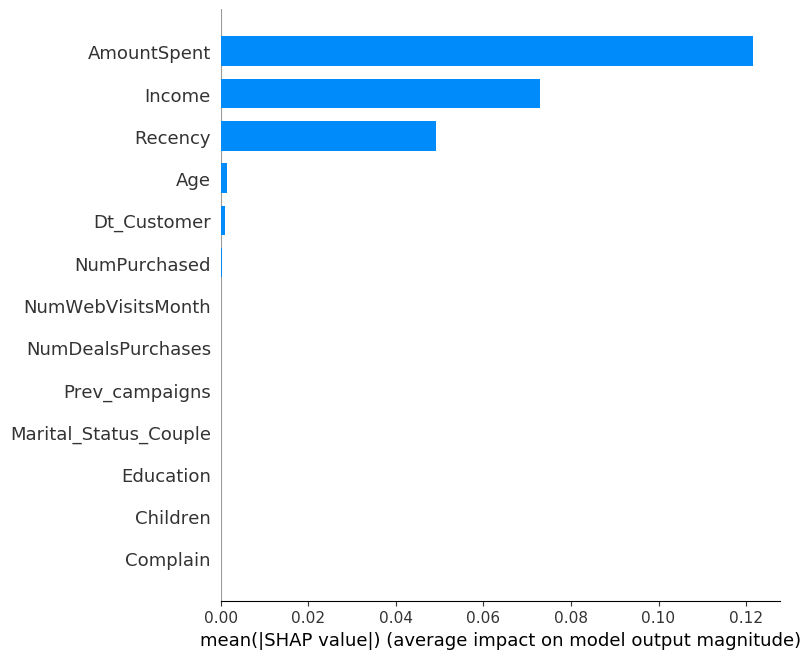

In [66]:
# SHAP variable importance for a Linear Model
shap.summary_plot(linear_shap_values, x_train, plot_type="bar")

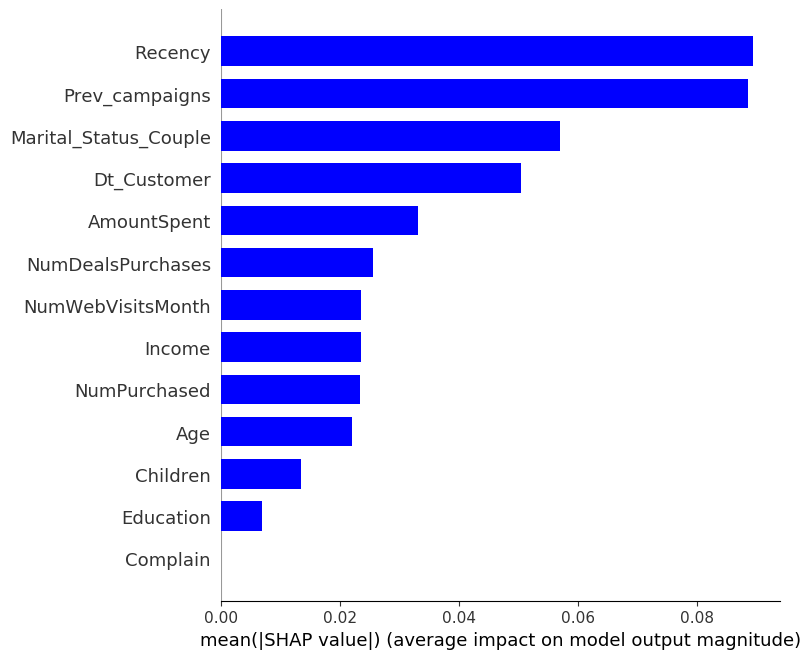

In [67]:
# SHAP variable importance for Tree based model
shap.summary_plot(tree_shap_values, x_train, plot_type="bar", color="blue")

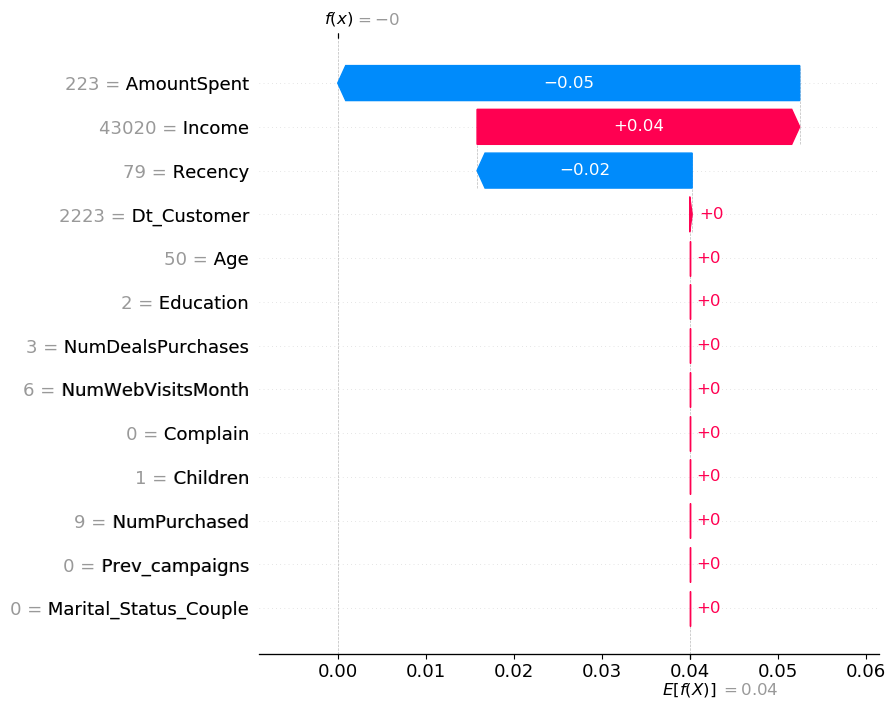

In [68]:
# Waterfall plot for linear model
shap.plots.waterfall(linear_shap_values[sample_ind], max_display=14)

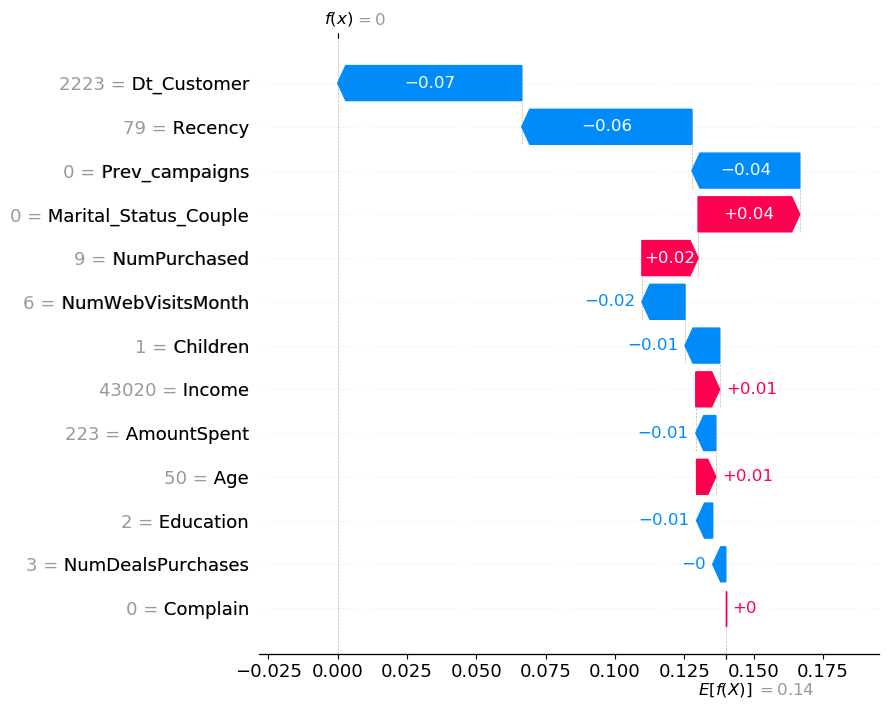

In [69]:
# Waterfall plot for Tree Based Model
shap.plots.waterfall(tree_shap_values[sample_ind], max_display=14)

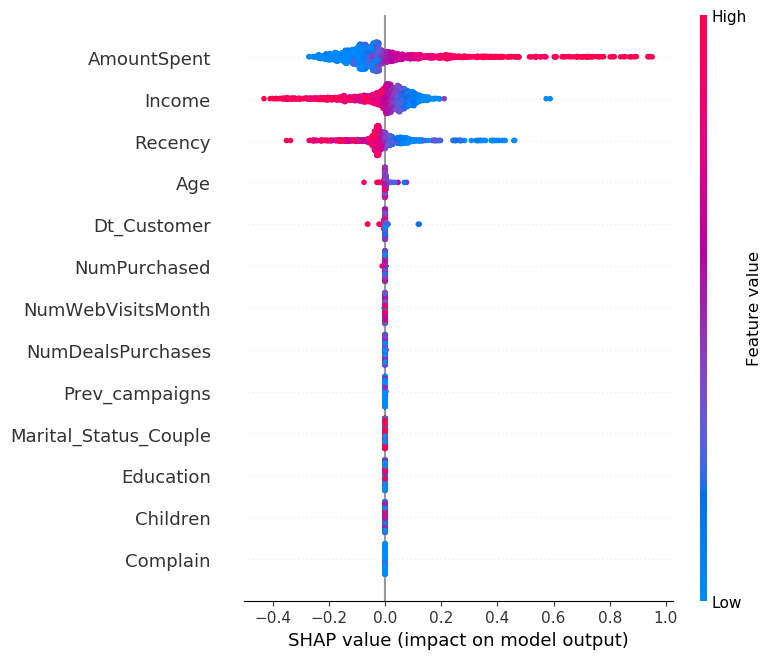

In [70]:
# SHAP summary for Linear Model
shap.summary_plot(linear_shap_values, x_train)

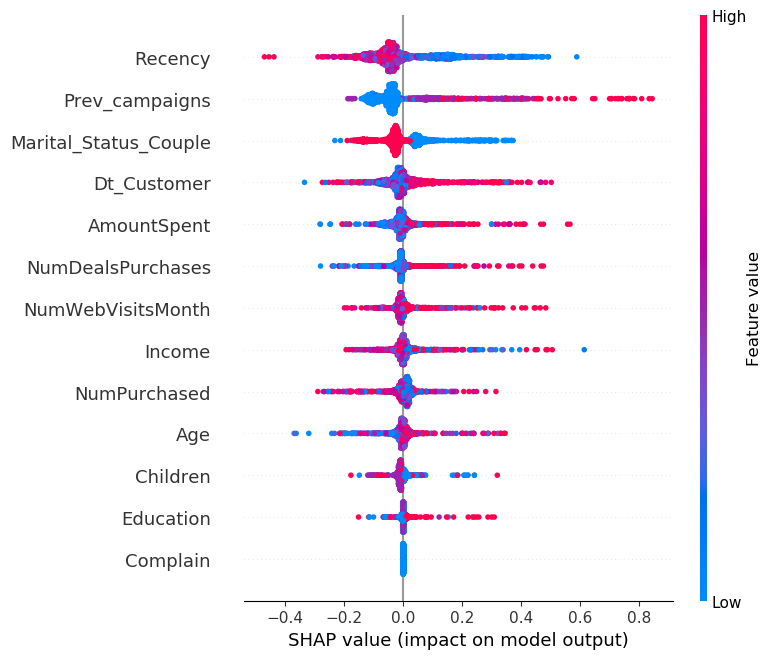

In [71]:
# SHAP summary for Tree Based Model
shap.summary_plot(tree_shap_values, x_train)

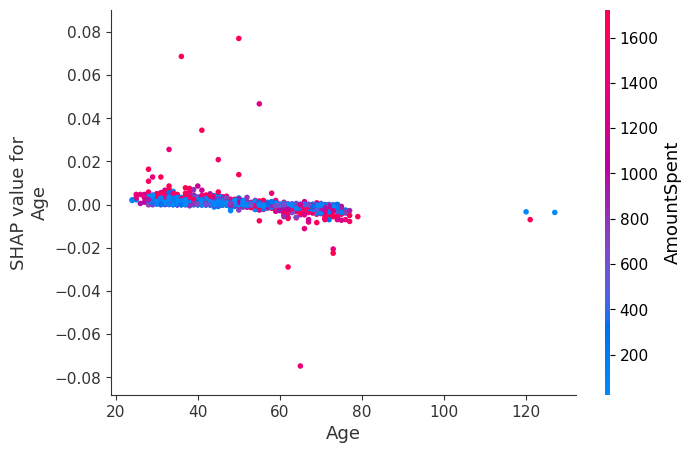

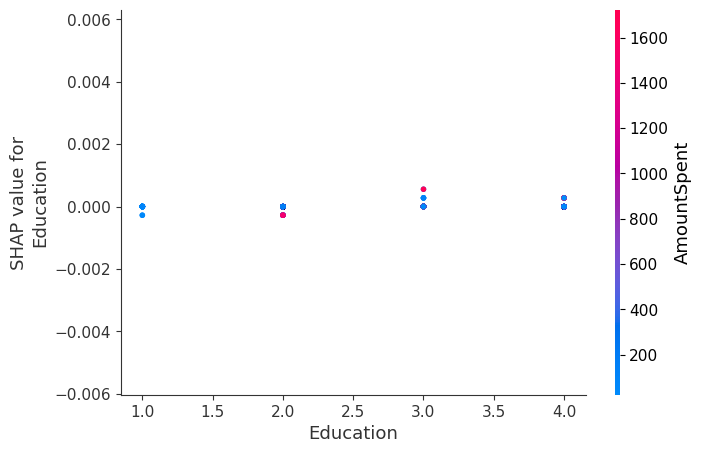

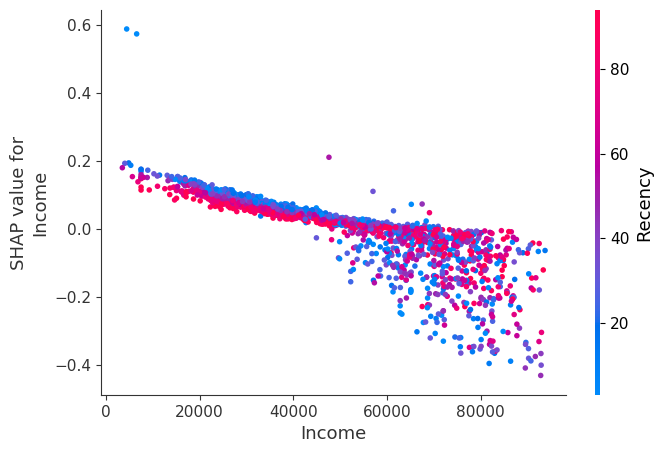

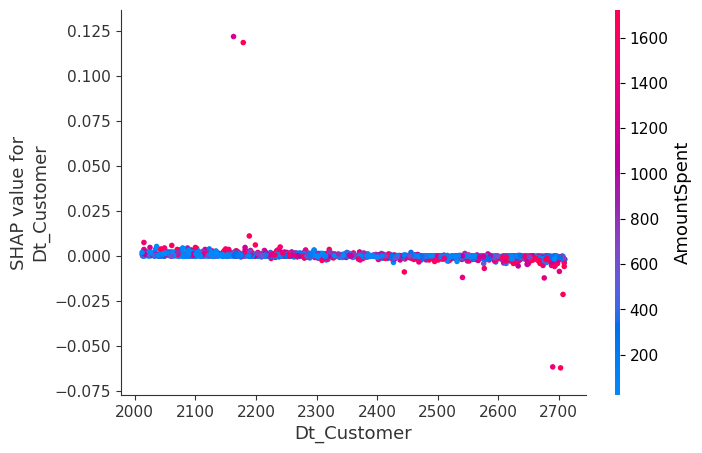

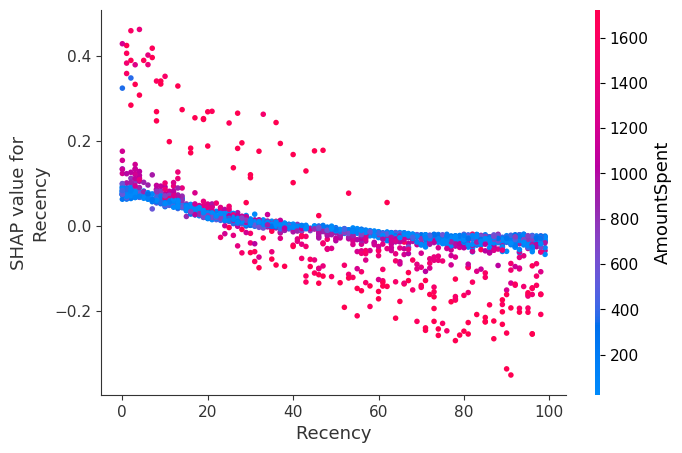

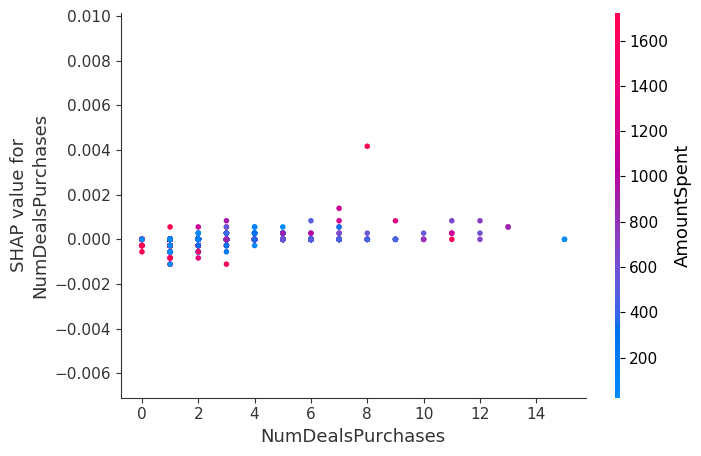

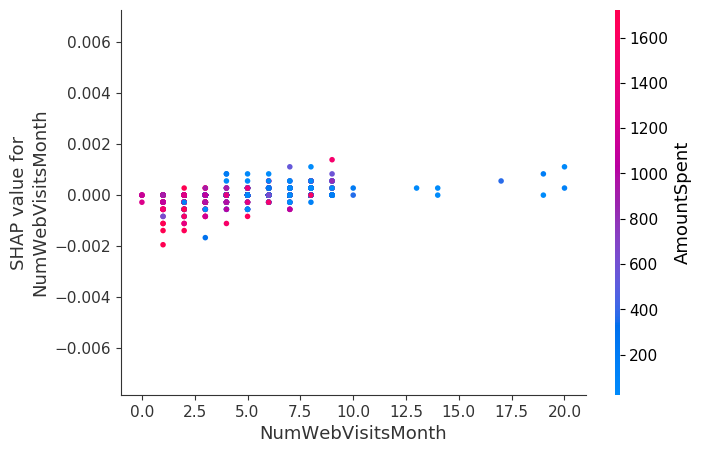

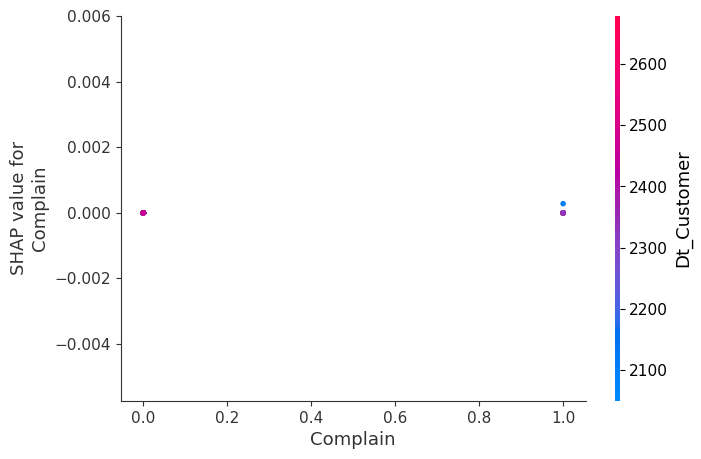

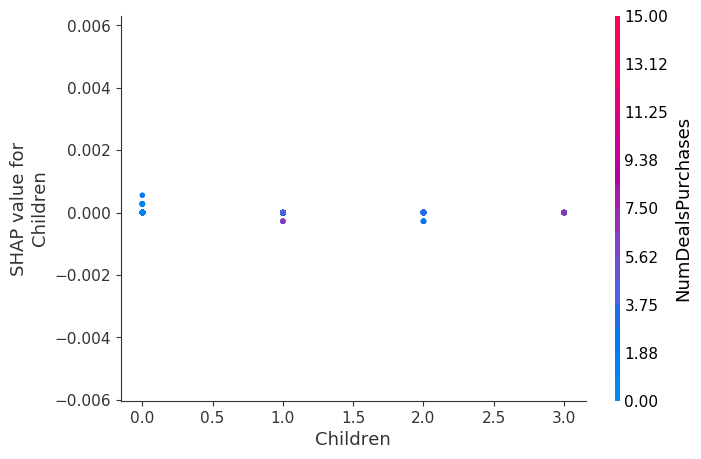

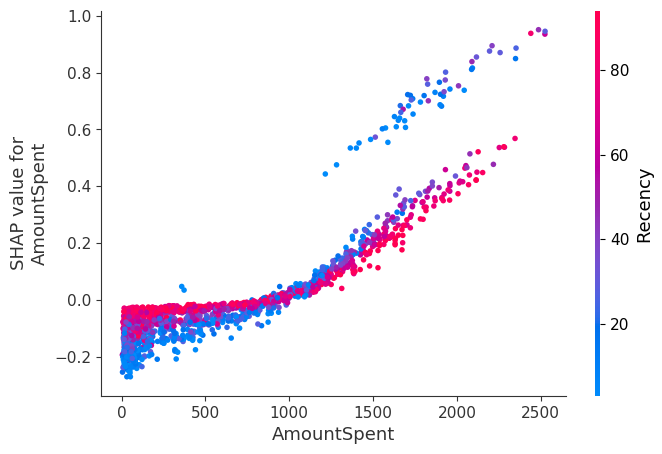

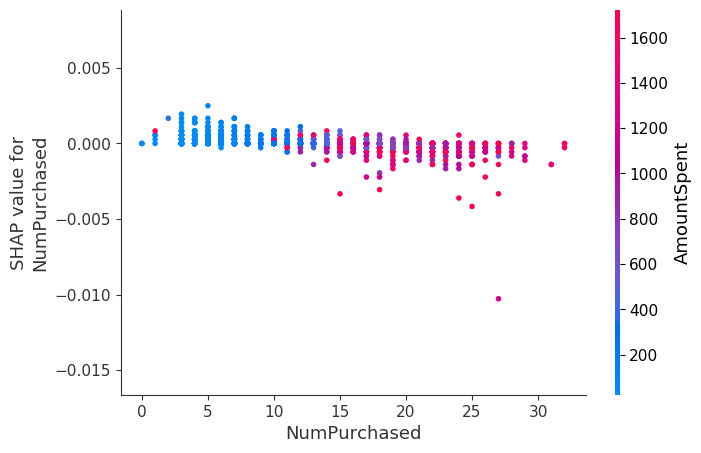

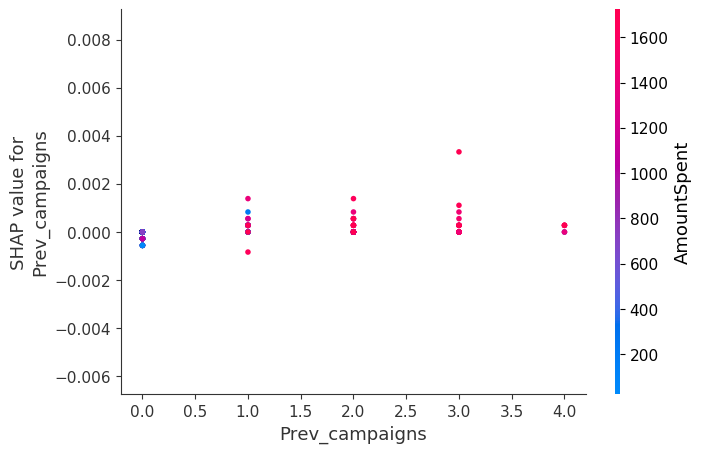

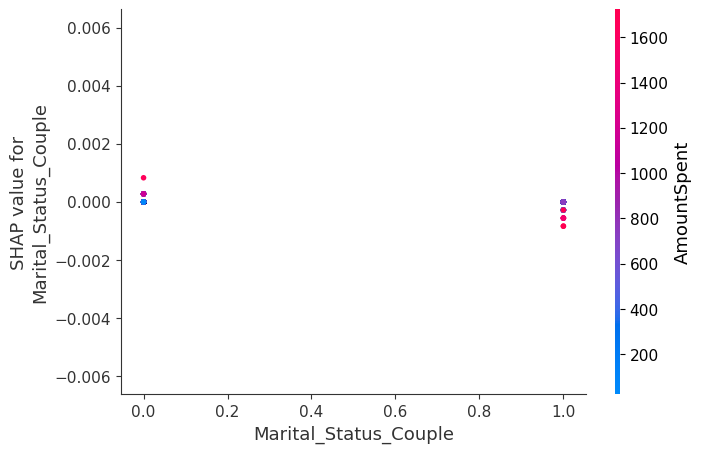

In [72]:
# SHAP partial dependence plot for linear model
for i in x_train.columns:
    shap.dependence_plot(i, linear_shap_values.values, x_train)

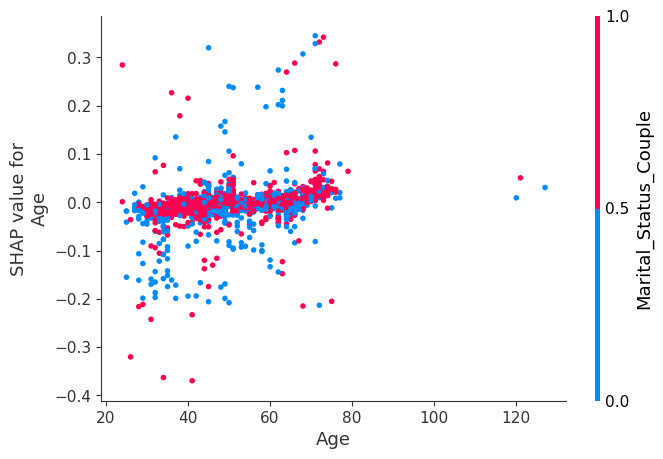

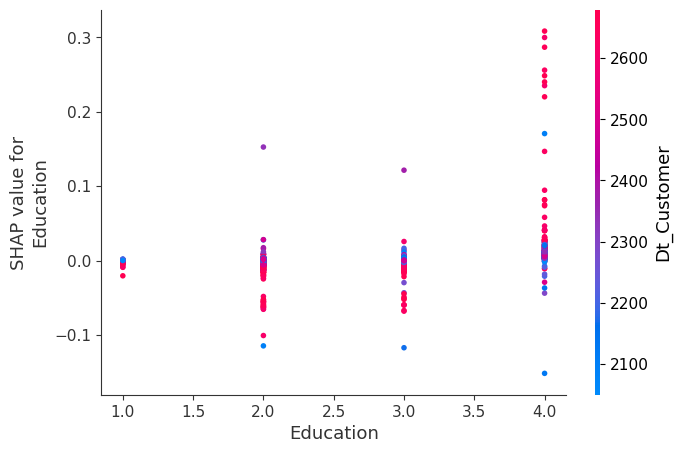

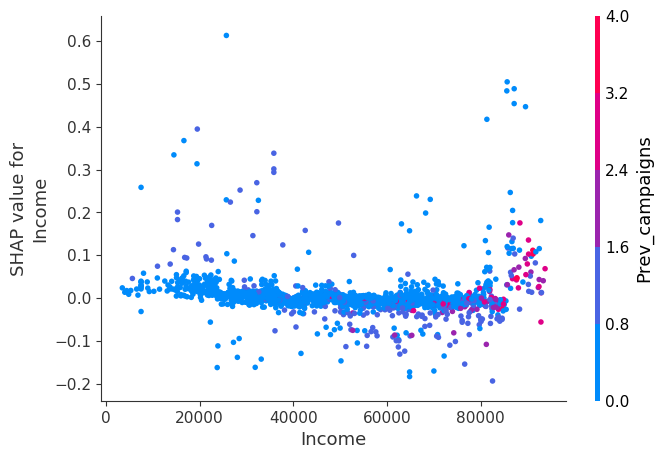

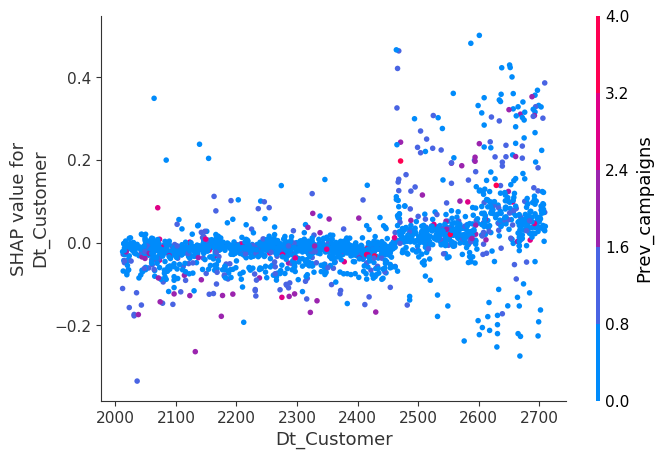

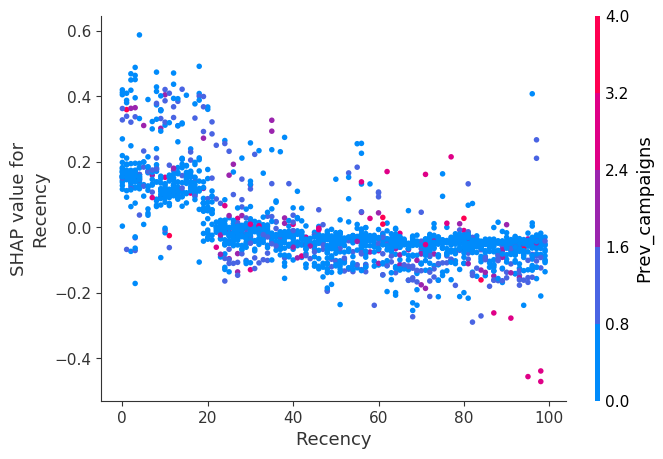

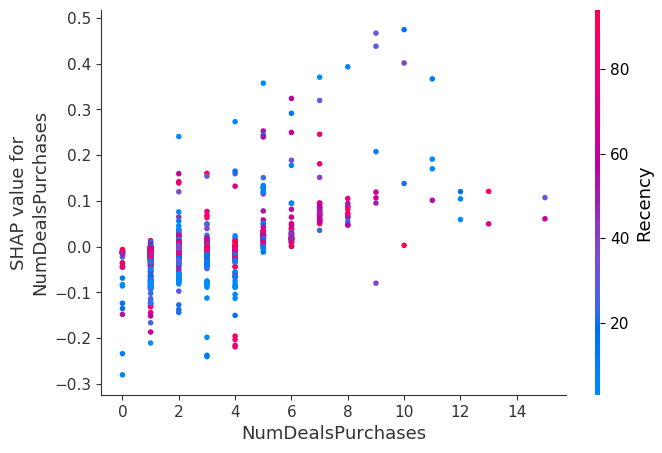

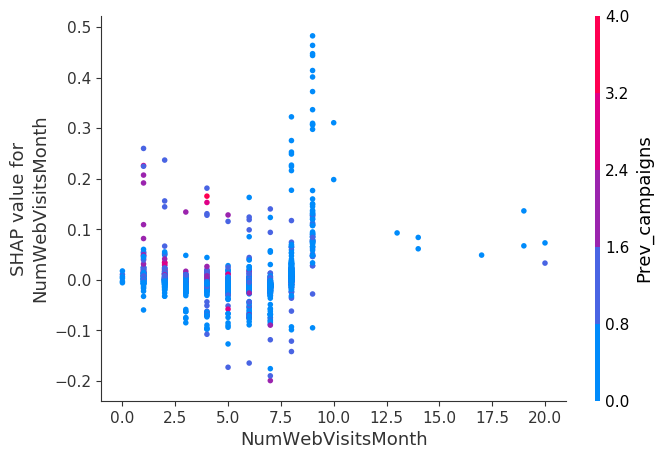

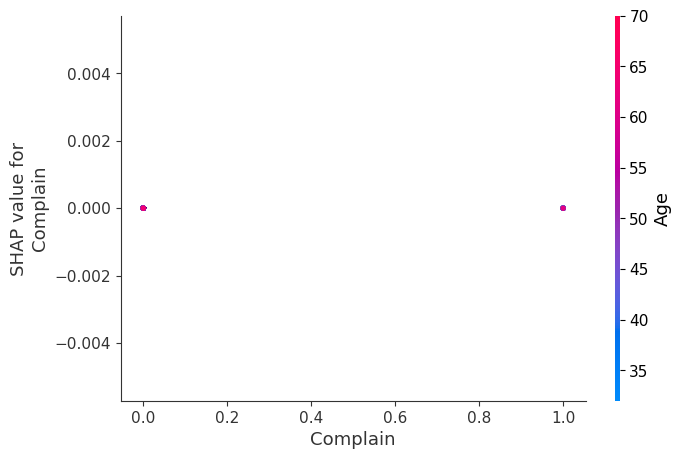

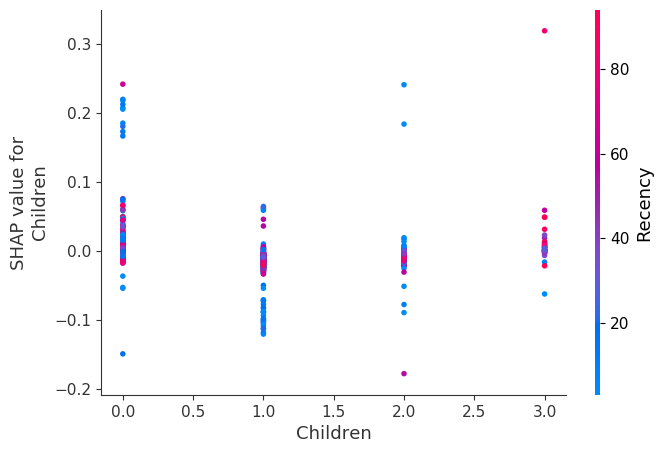

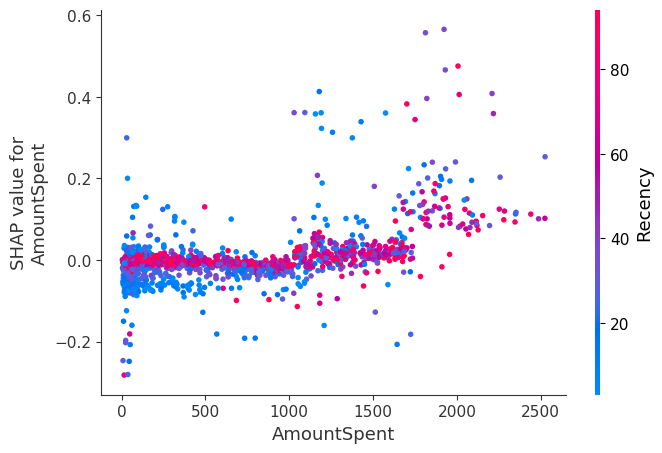

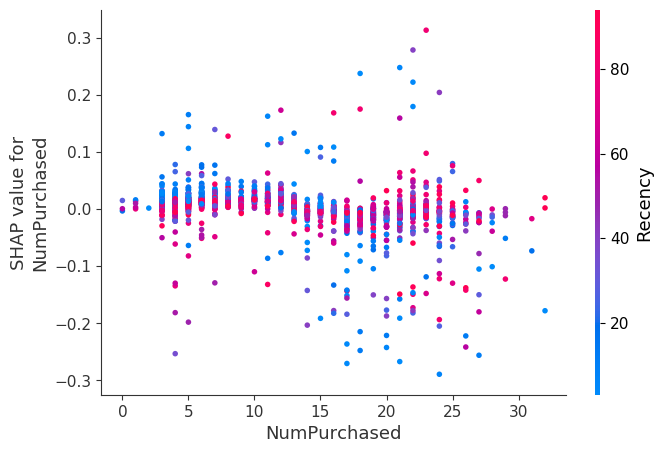

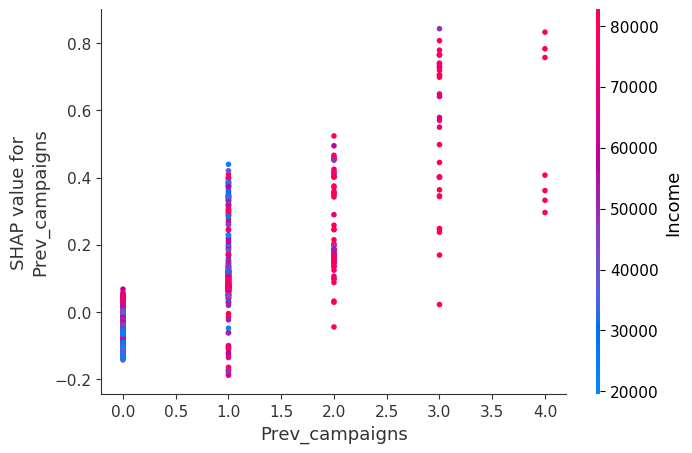

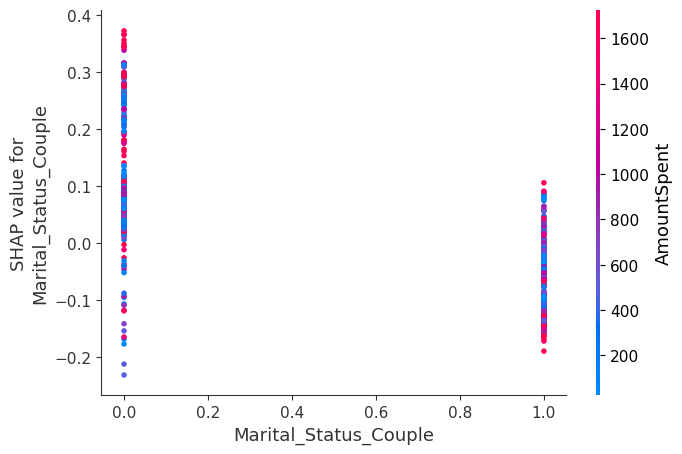

In [73]:
# SHAP partial dependence plot for a tree based model
for i in x_train.columns:
    shap.dependence_plot(i, tree_shap_values.values, x_train)

/Users/makarandmadhavi/opt/miniconda3/lib/python3.9/site-packages/sklearn/inspection/_partial_dependence.py:153: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_eval.iloc[:, variable] = new_values[i]
/Users/makarandmadhavi/opt/miniconda3/lib/python3.9/site-packages/sklearn/inspection/_partial_dependence.py:153: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_eval.iloc[:, variable] = new_values[i]
/Users/makarandmadhavi/opt/miniconda3/lib/python3.9/site-packages/sklearn/inspection/_partial_dependence.py:153: FutureWarning: In a future version, `df.ilo

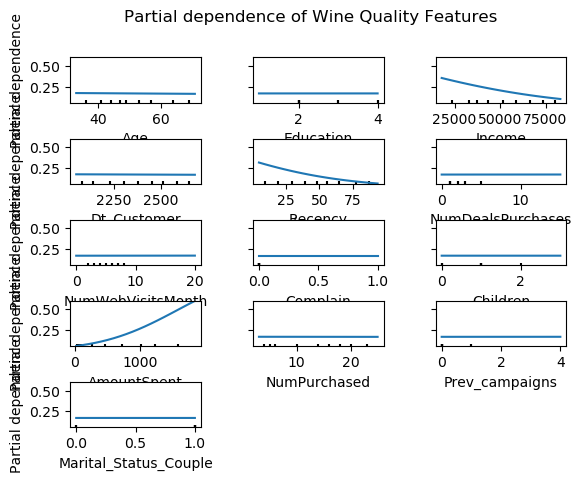

In [76]:
from sklearn.inspection import plot_partial_dependence

plot_partial_dependence(
    logreg, x_test, x_test.columns, n_jobs=3, grid_resolution=20
)

fig = plt.gcf()
fig.suptitle("Partial dependence of Wine Quality Features")
fig.subplots_adjust(wspace=0.4, hspace=0.8)
plt.show()
plt.rcParams["figure.figsize"] = (32, 24)

/Users/makarandmadhavi/opt/miniconda3/lib/python3.9/site-packages/sklearn/inspection/_partial_dependence.py:153: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_eval.iloc[:, variable] = new_values[i]
/Users/makarandmadhavi/opt/miniconda3/lib/python3.9/site-packages/sklearn/inspection/_partial_dependence.py:153: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_eval.iloc[:, variable] = new_values[i]
/Users/makarandmadhavi/opt/miniconda3/lib/python3.9/site-packages/sklearn/inspection/_partial_dependence.py:153: FutureWarning: In a future version, `df.ilo

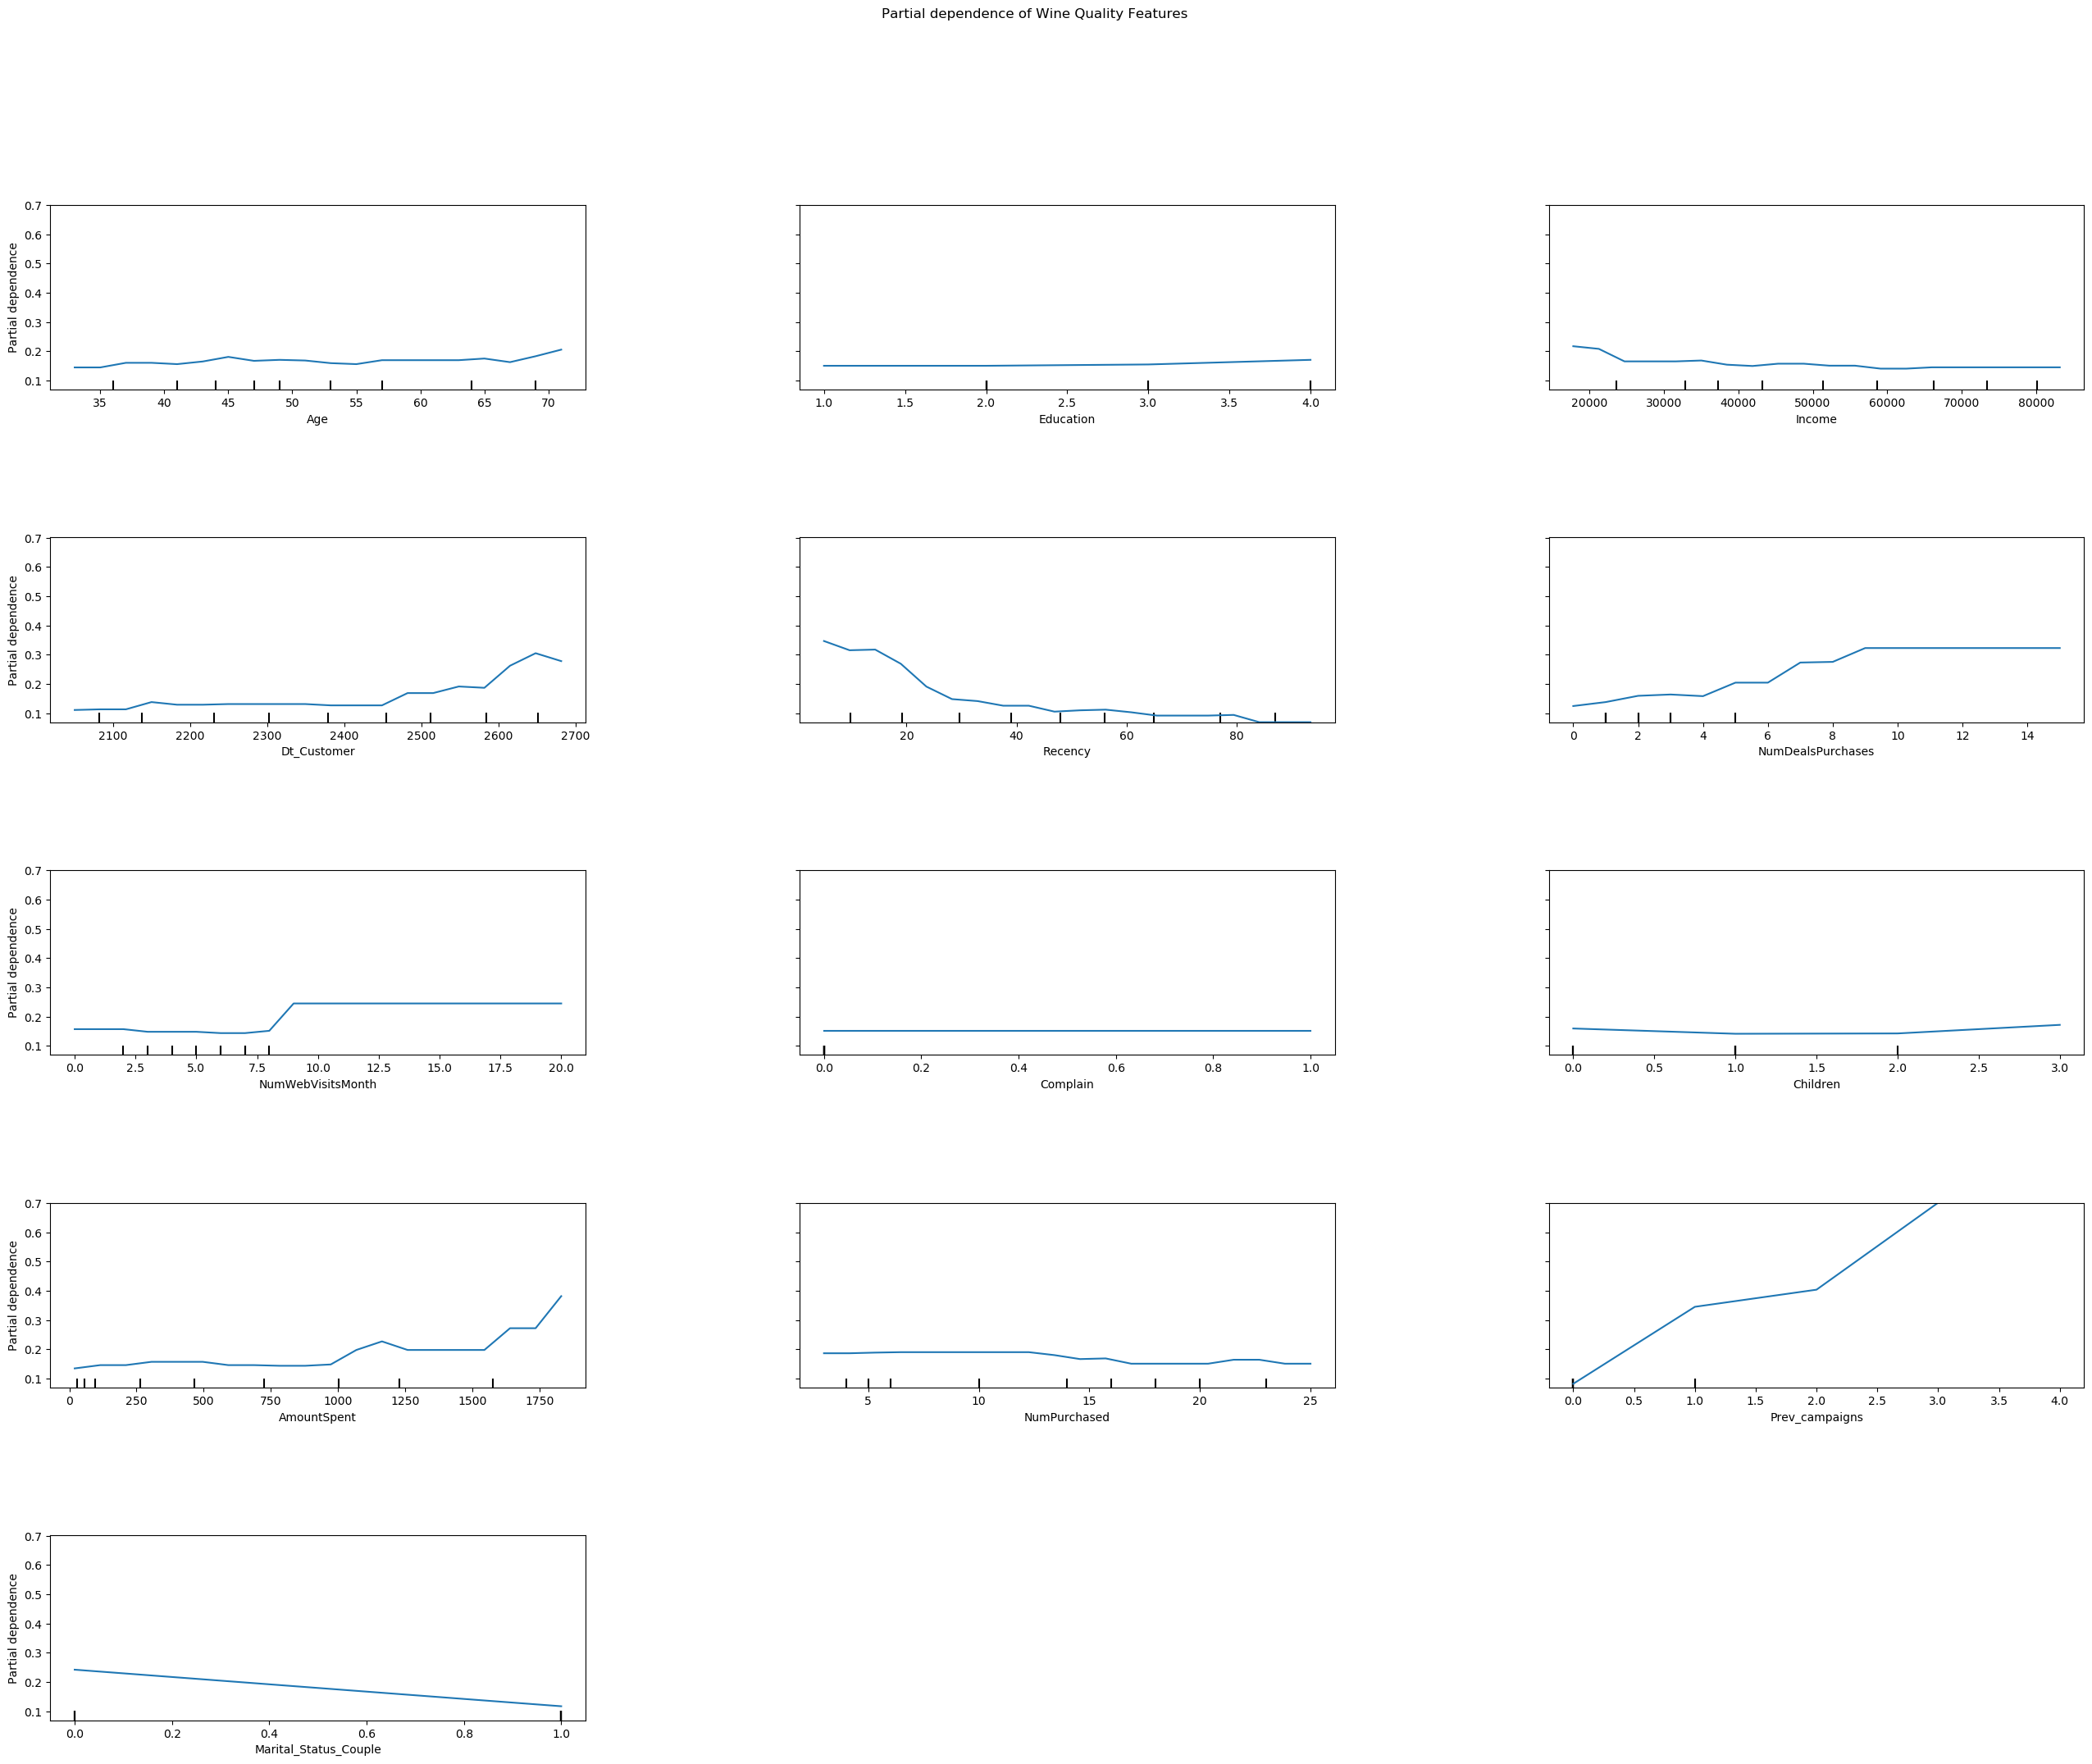

In [77]:
# PDP Plot for Tree based Model
plot_partial_dependence(
    dtc, x_test, x_test.columns, n_jobs=3, grid_resolution=20
)


fig = plt.gcf()
fig.suptitle("Partial dependence of Wine Quality Features")
fig.subplots_adjust(wspace=0.4, hspace=0.8)
plt.show()
plt.rcParams["figure.figsize"] = (32, 24)

# Comparision between SHAP and Partial Dependence Plot Analysis
SHAP uses the black-box model to calculate the marginal contribution to the prediction for each feature and then relies on the theoretically sound game theory concept of Shapley values to calculate the feature importance. In this way

1. PDP gives the extent of effect a variable has on the output by freezing the rest of them
2. SHAP gives how much each variable contributes to the prediction

We have to analyze our needs and then consider the tradeoff to select the best suitable interpretable method for the ML model